<a href="https://colab.research.google.com/github/erickcori/Delphi_CIA_XAI_WaterReuse/blob/main/notebooks/01_PCA_BarrierImpactPatterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

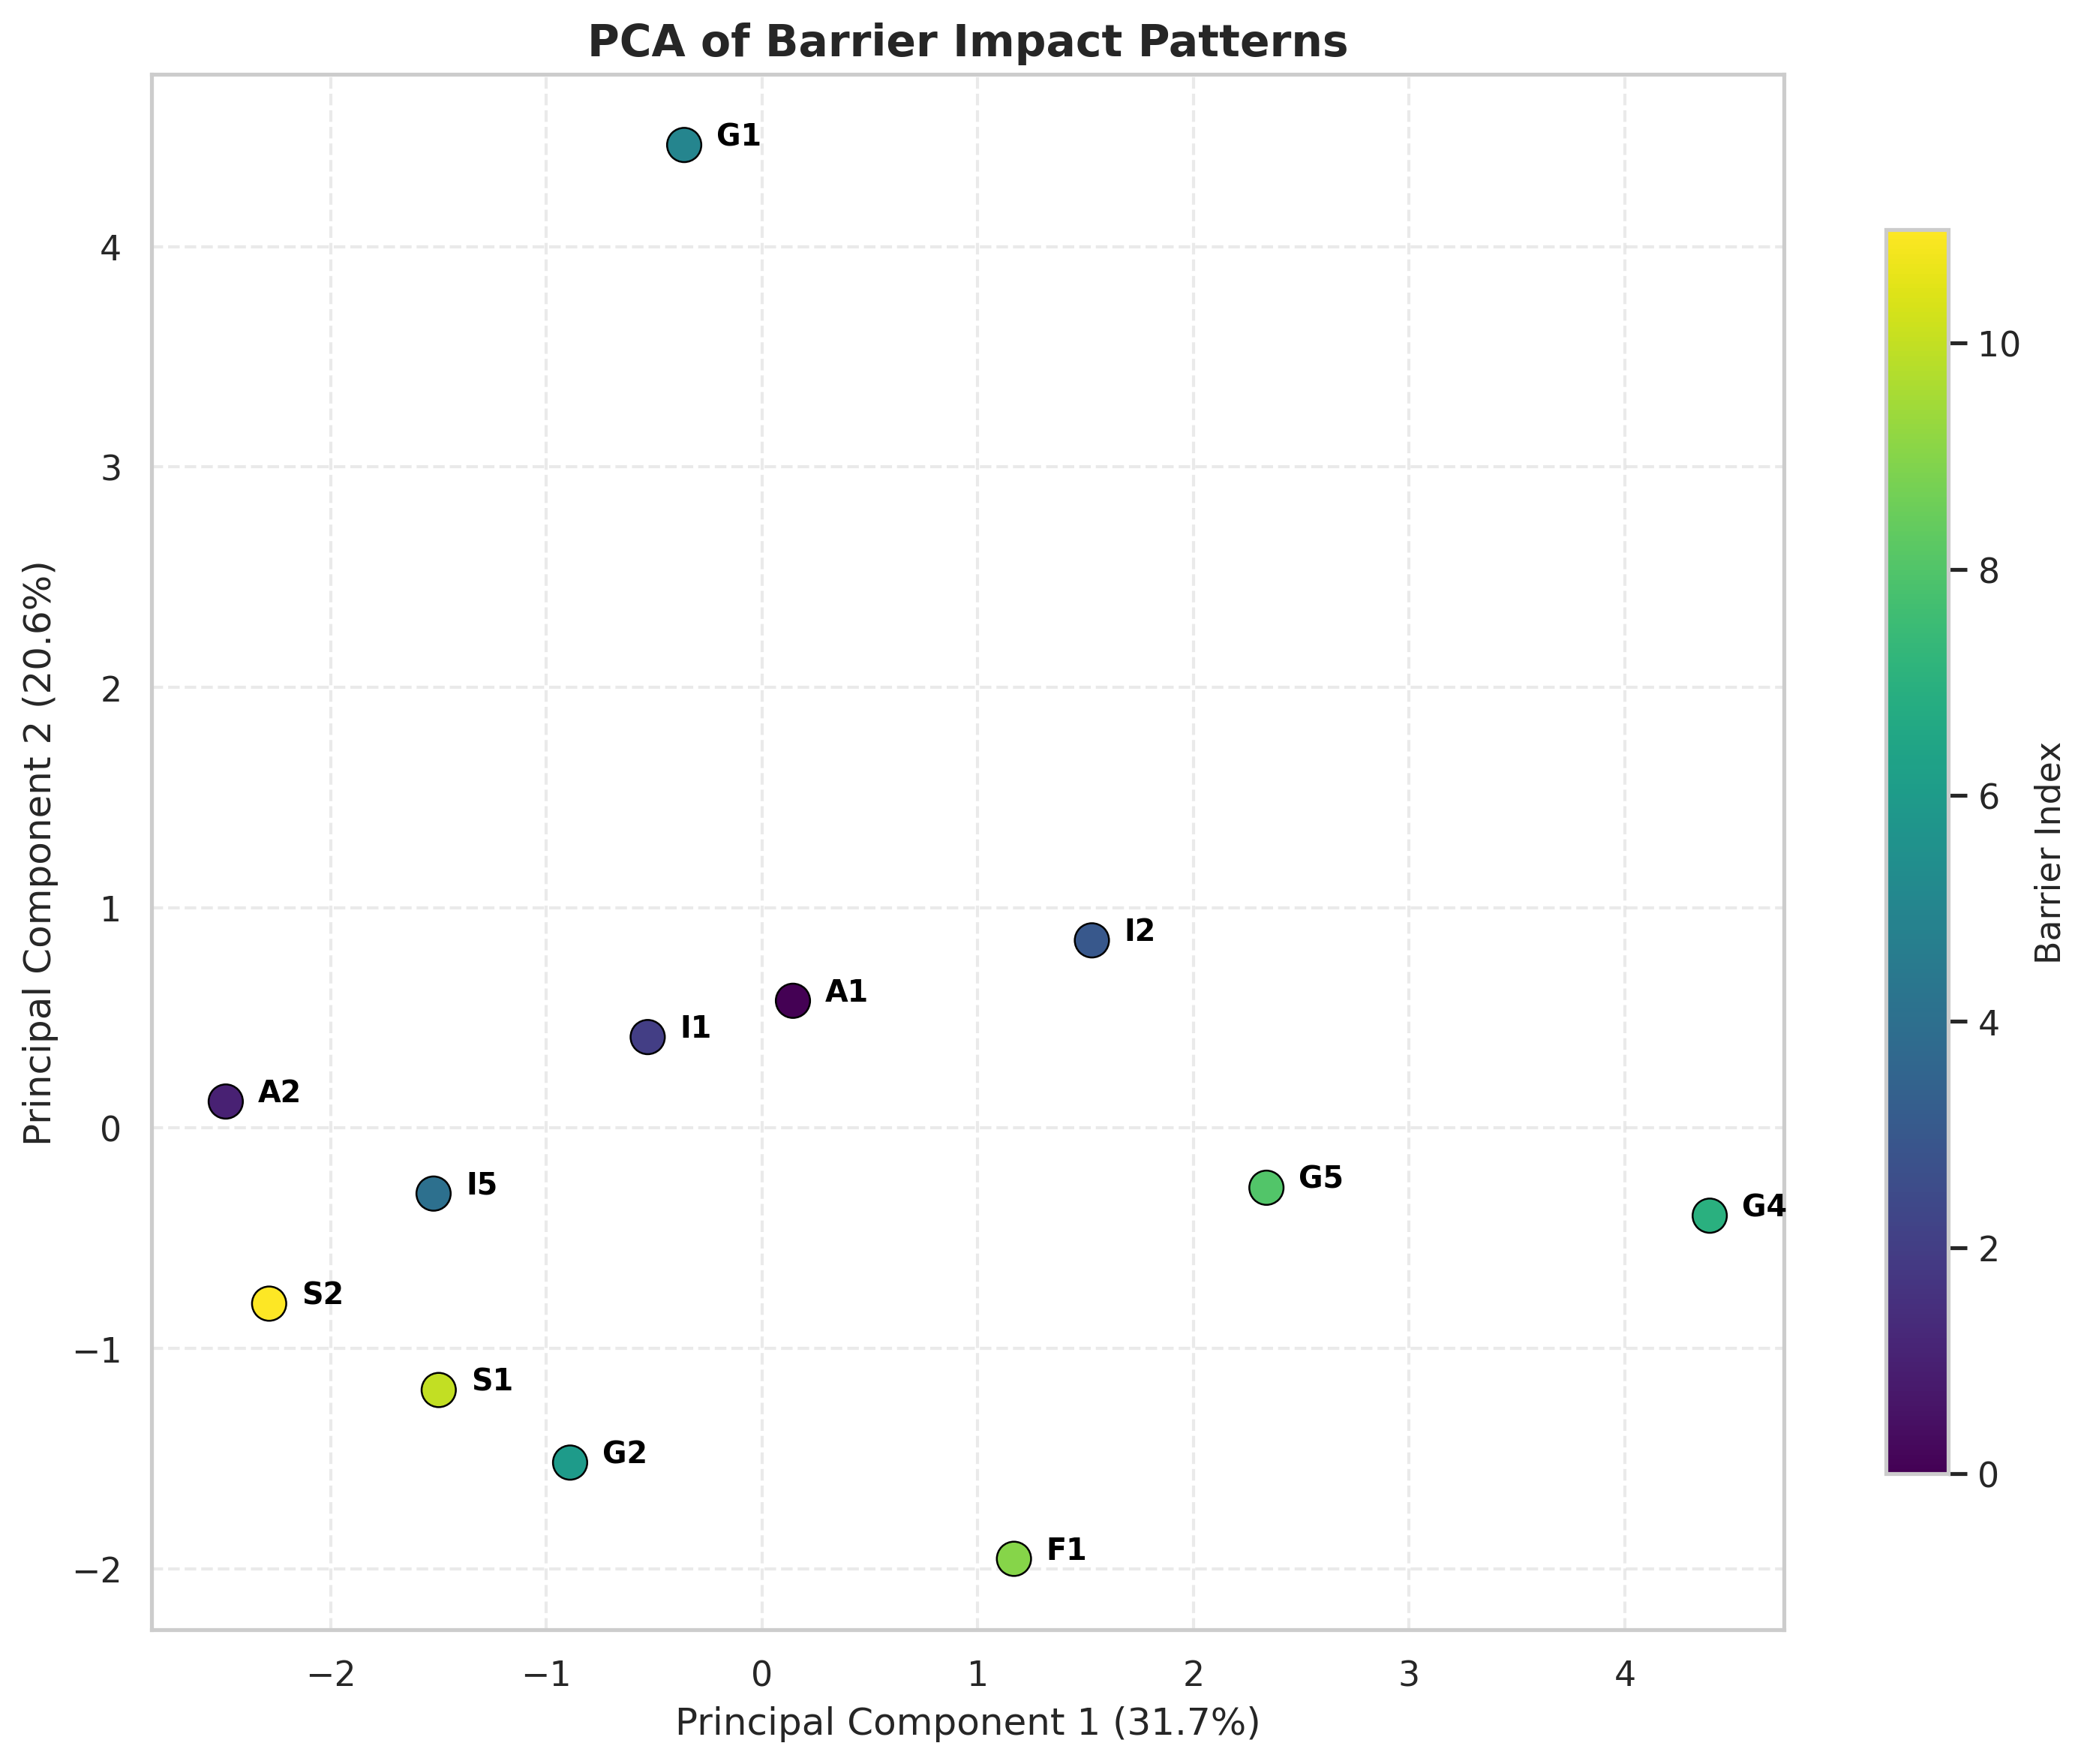

In [27]:
###PCA of Barrier Impact Patterns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Build the PCA matrix
df_matrix = pd.DataFrame(cross_impact, index=barriers, columns=barriers)
df_matrix.fillna(0, inplace=True)

X_scaled = StandardScaler().fit_transform(df_matrix)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Plot (optimized for publication)
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Scatter plot
scatter = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=range(len(barriers)),
    cmap="viridis",
    s=120,
    edgecolor='black',
    linewidth=0.6
)

# Add labels with spacing
for i, label in enumerate(barriers):
    ax.text(pca_result[i, 0] + 0.15, pca_result[i, 1], label,
            fontsize=9.5, fontweight='bold', color='black')

# Axes labels and title
explained_var = pca.explained_variance_ratio_ * 100
ax.set_xlabel(f"Principal Component 1 ({explained_var[0]:.1f}%)", fontsize=12)
ax.set_ylabel(f"Principal Component 2 ({explained_var[1]:.1f}%)", fontsize=12)
ax.set_title("PCA of Barrier Impact Patterns", fontsize=14, weight='bold')

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.4)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label("Barrier Index", fontsize=11)

plt.tight_layout()
plt.show()

<Figure size 2400x1800 with 0 Axes>

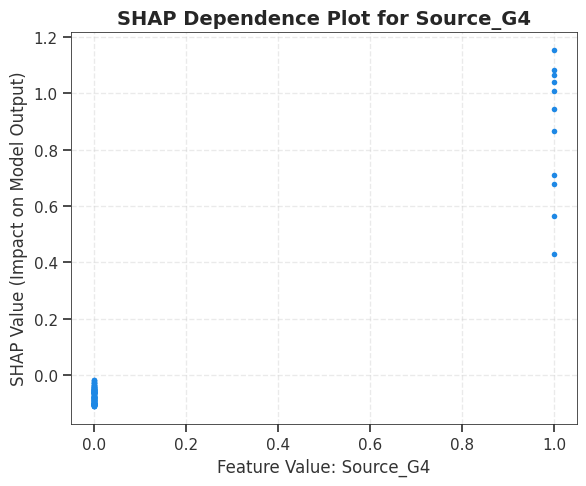

In [40]:
###SHAP Dependence Plot for Source_G4
import shap
import matplotlib.pyplot as plt

# Crear figura nueva con 300 DPI
fig = plt.figure(figsize=(8, 6), dpi=300)

# Dependence plot SHAP (con estilo y sin mostrar aún)
shap.dependence_plot(
    "Source_G4",
    shap_values.values,
    X,
    interaction_index=None,
    show=False  # importante para modificar luego
)

# Acceder al eje activo
ax = plt.gca()

# Personalización editorial
ax.set_title("SHAP Dependence Plot for Source_G4", fontsize=14, weight='bold')
ax.set_xlabel("Feature Value: Source_G4", fontsize=12)
ax.set_ylabel("SHAP Value (Impact on Model Output)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.4)

# Estilo limpio de ejes
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.6)

plt.tight_layout()
plt.show()

# OPCIONAL: guardar en alta calidad para publicar
# fig.savefig("SHAP_dependence_Source_G4.png", dpi=300, bbox_inches='tight')

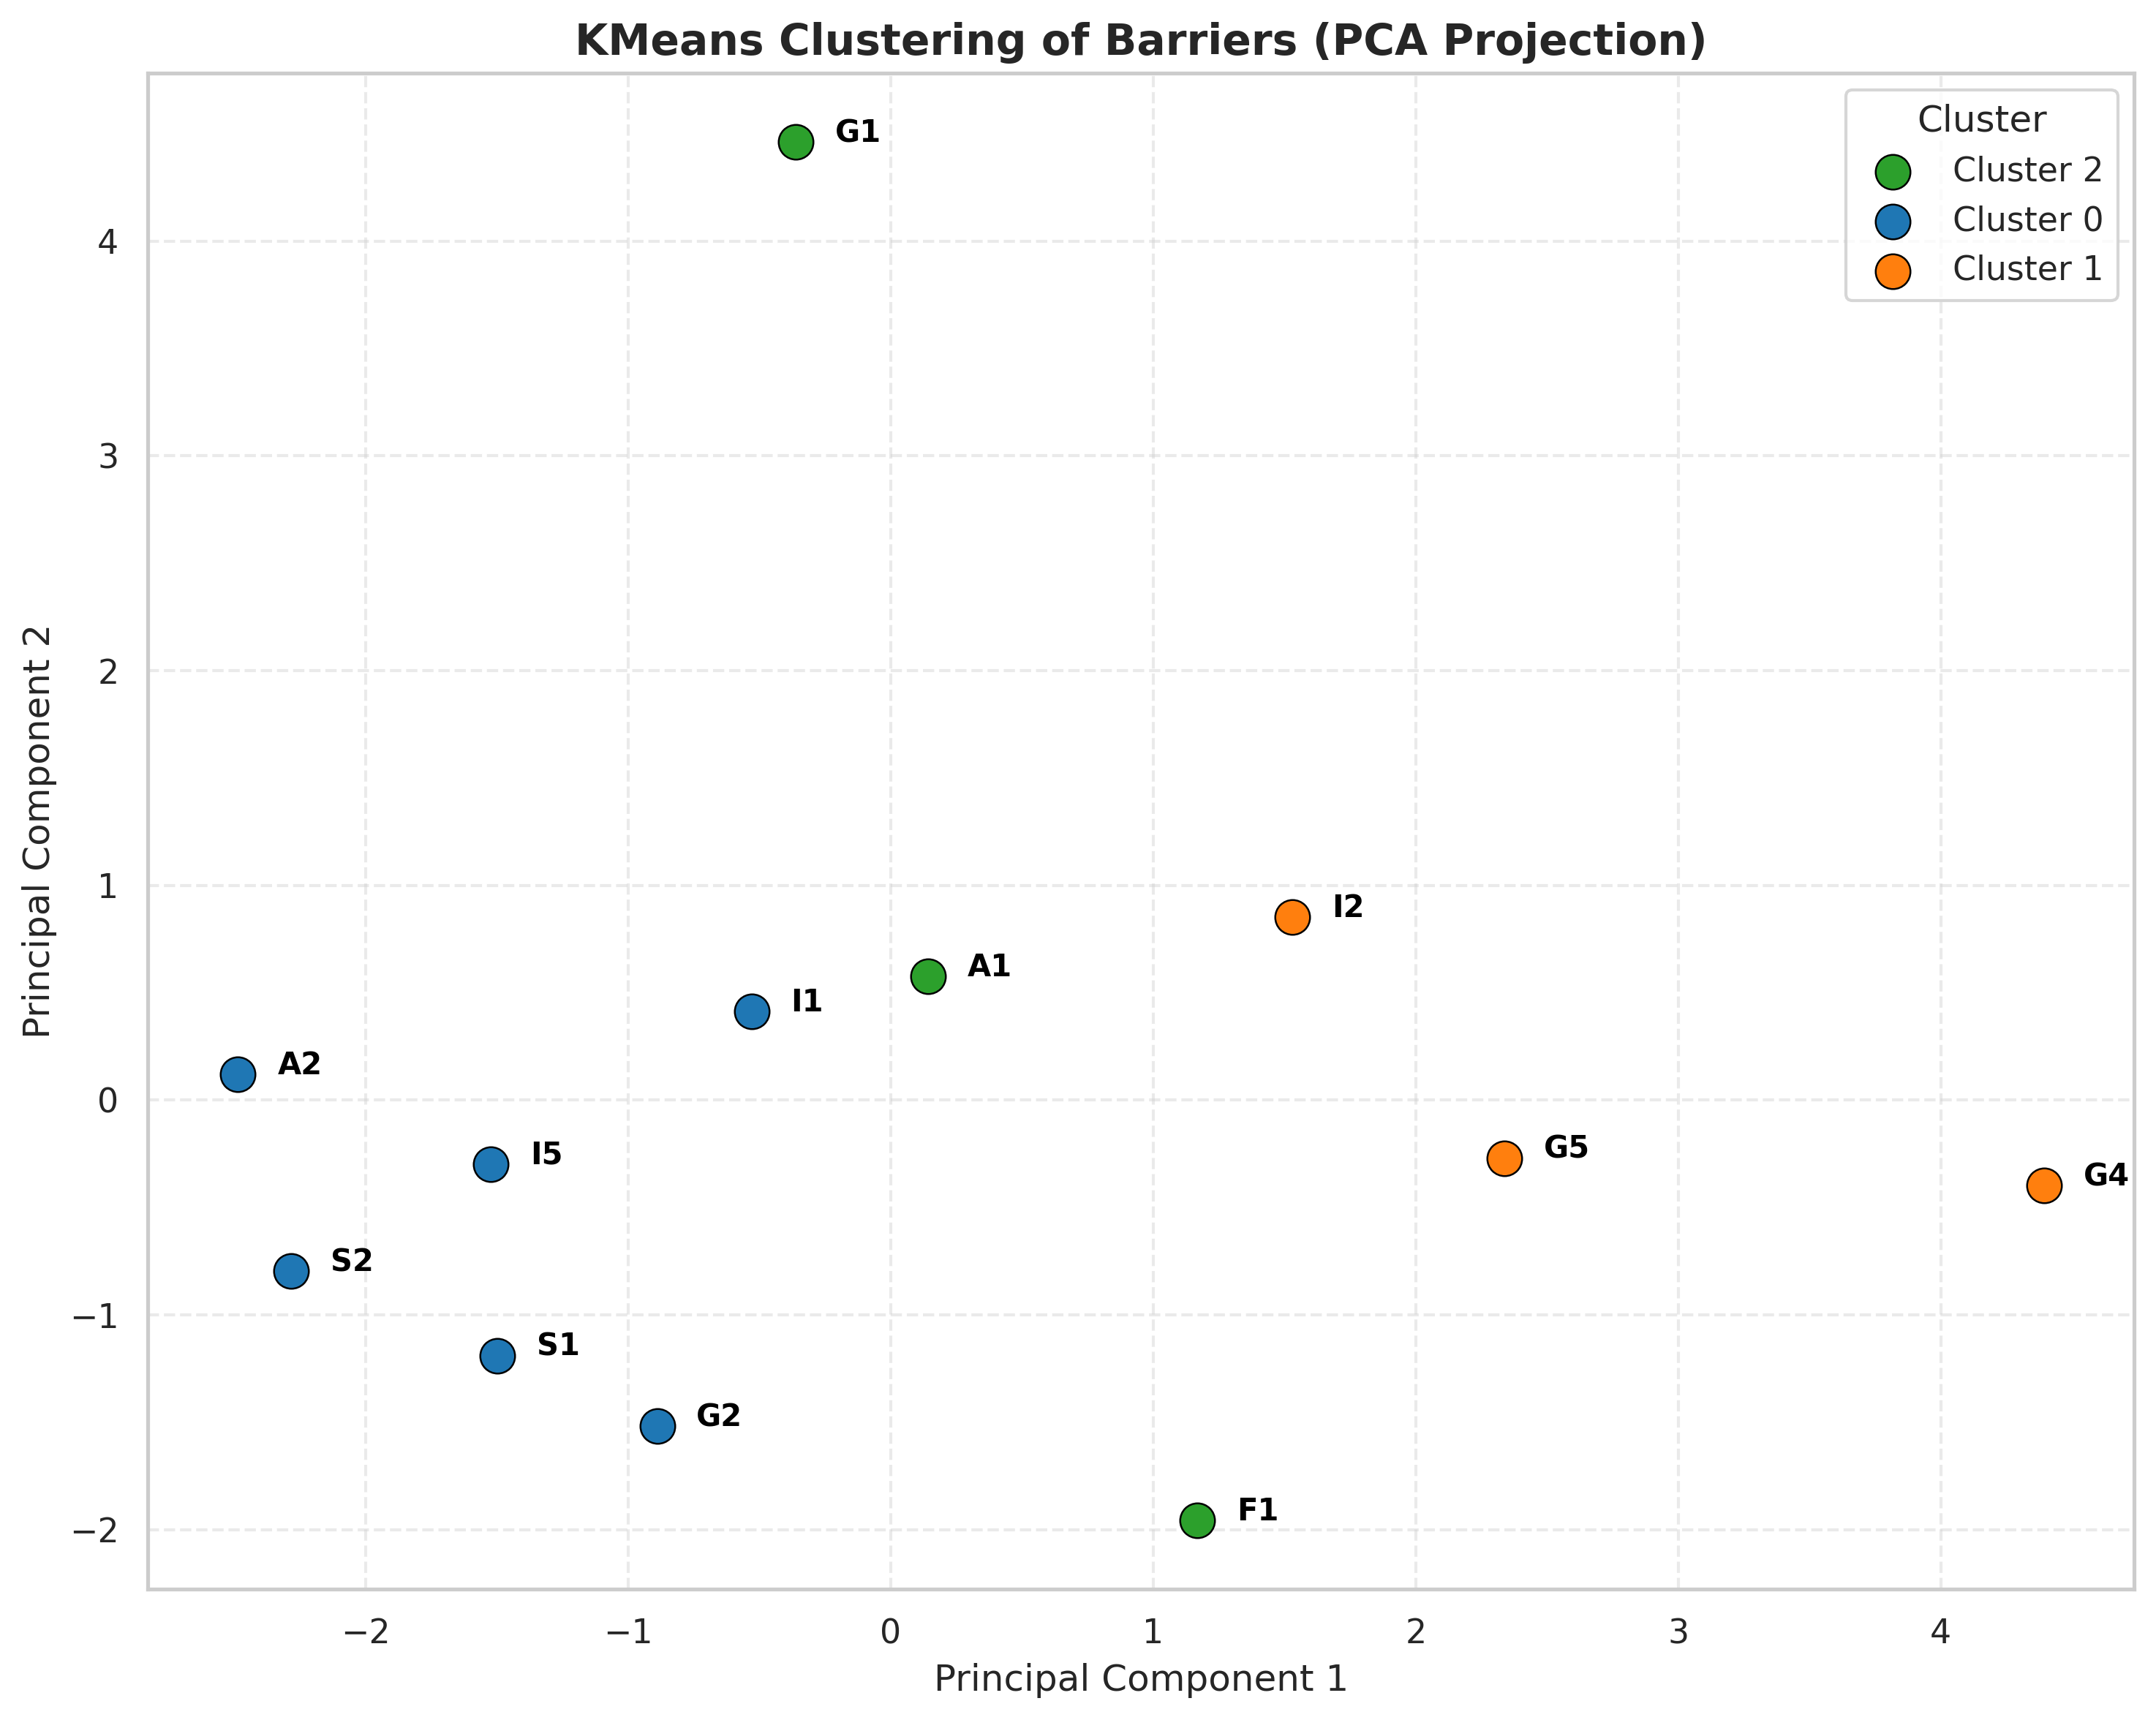

In [26]:
###KMeans Clustering of Barriers (PCA Projection)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot high-resolution figure
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Assign color map
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # azul, naranja, verde

# Plot each cluster with consistent color
for i in range(len(barriers)):
    ax.scatter(
        pca_result[i, 0], pca_result[i, 1],
        s=130,
        c=colors[clusters[i]],
        edgecolor='black',
        linewidth=0.6,
        label=f"Cluster {clusters[i]}" if f"Cluster {clusters[i]}" not in ax.get_legend_handles_labels()[1] else None
    )
    ax.text(pca_result[i, 0] + 0.15, pca_result[i, 1], barriers[i],
            fontsize=10, weight='bold', color='black')

# Títulos y etiquetas
ax.set_title("KMeans Clustering of Barriers (PCA Projection)", fontsize=14, weight='bold')
ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.4)

# Leyenda
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title="Cluster", loc='best')

plt.tight_layout()
plt.show()

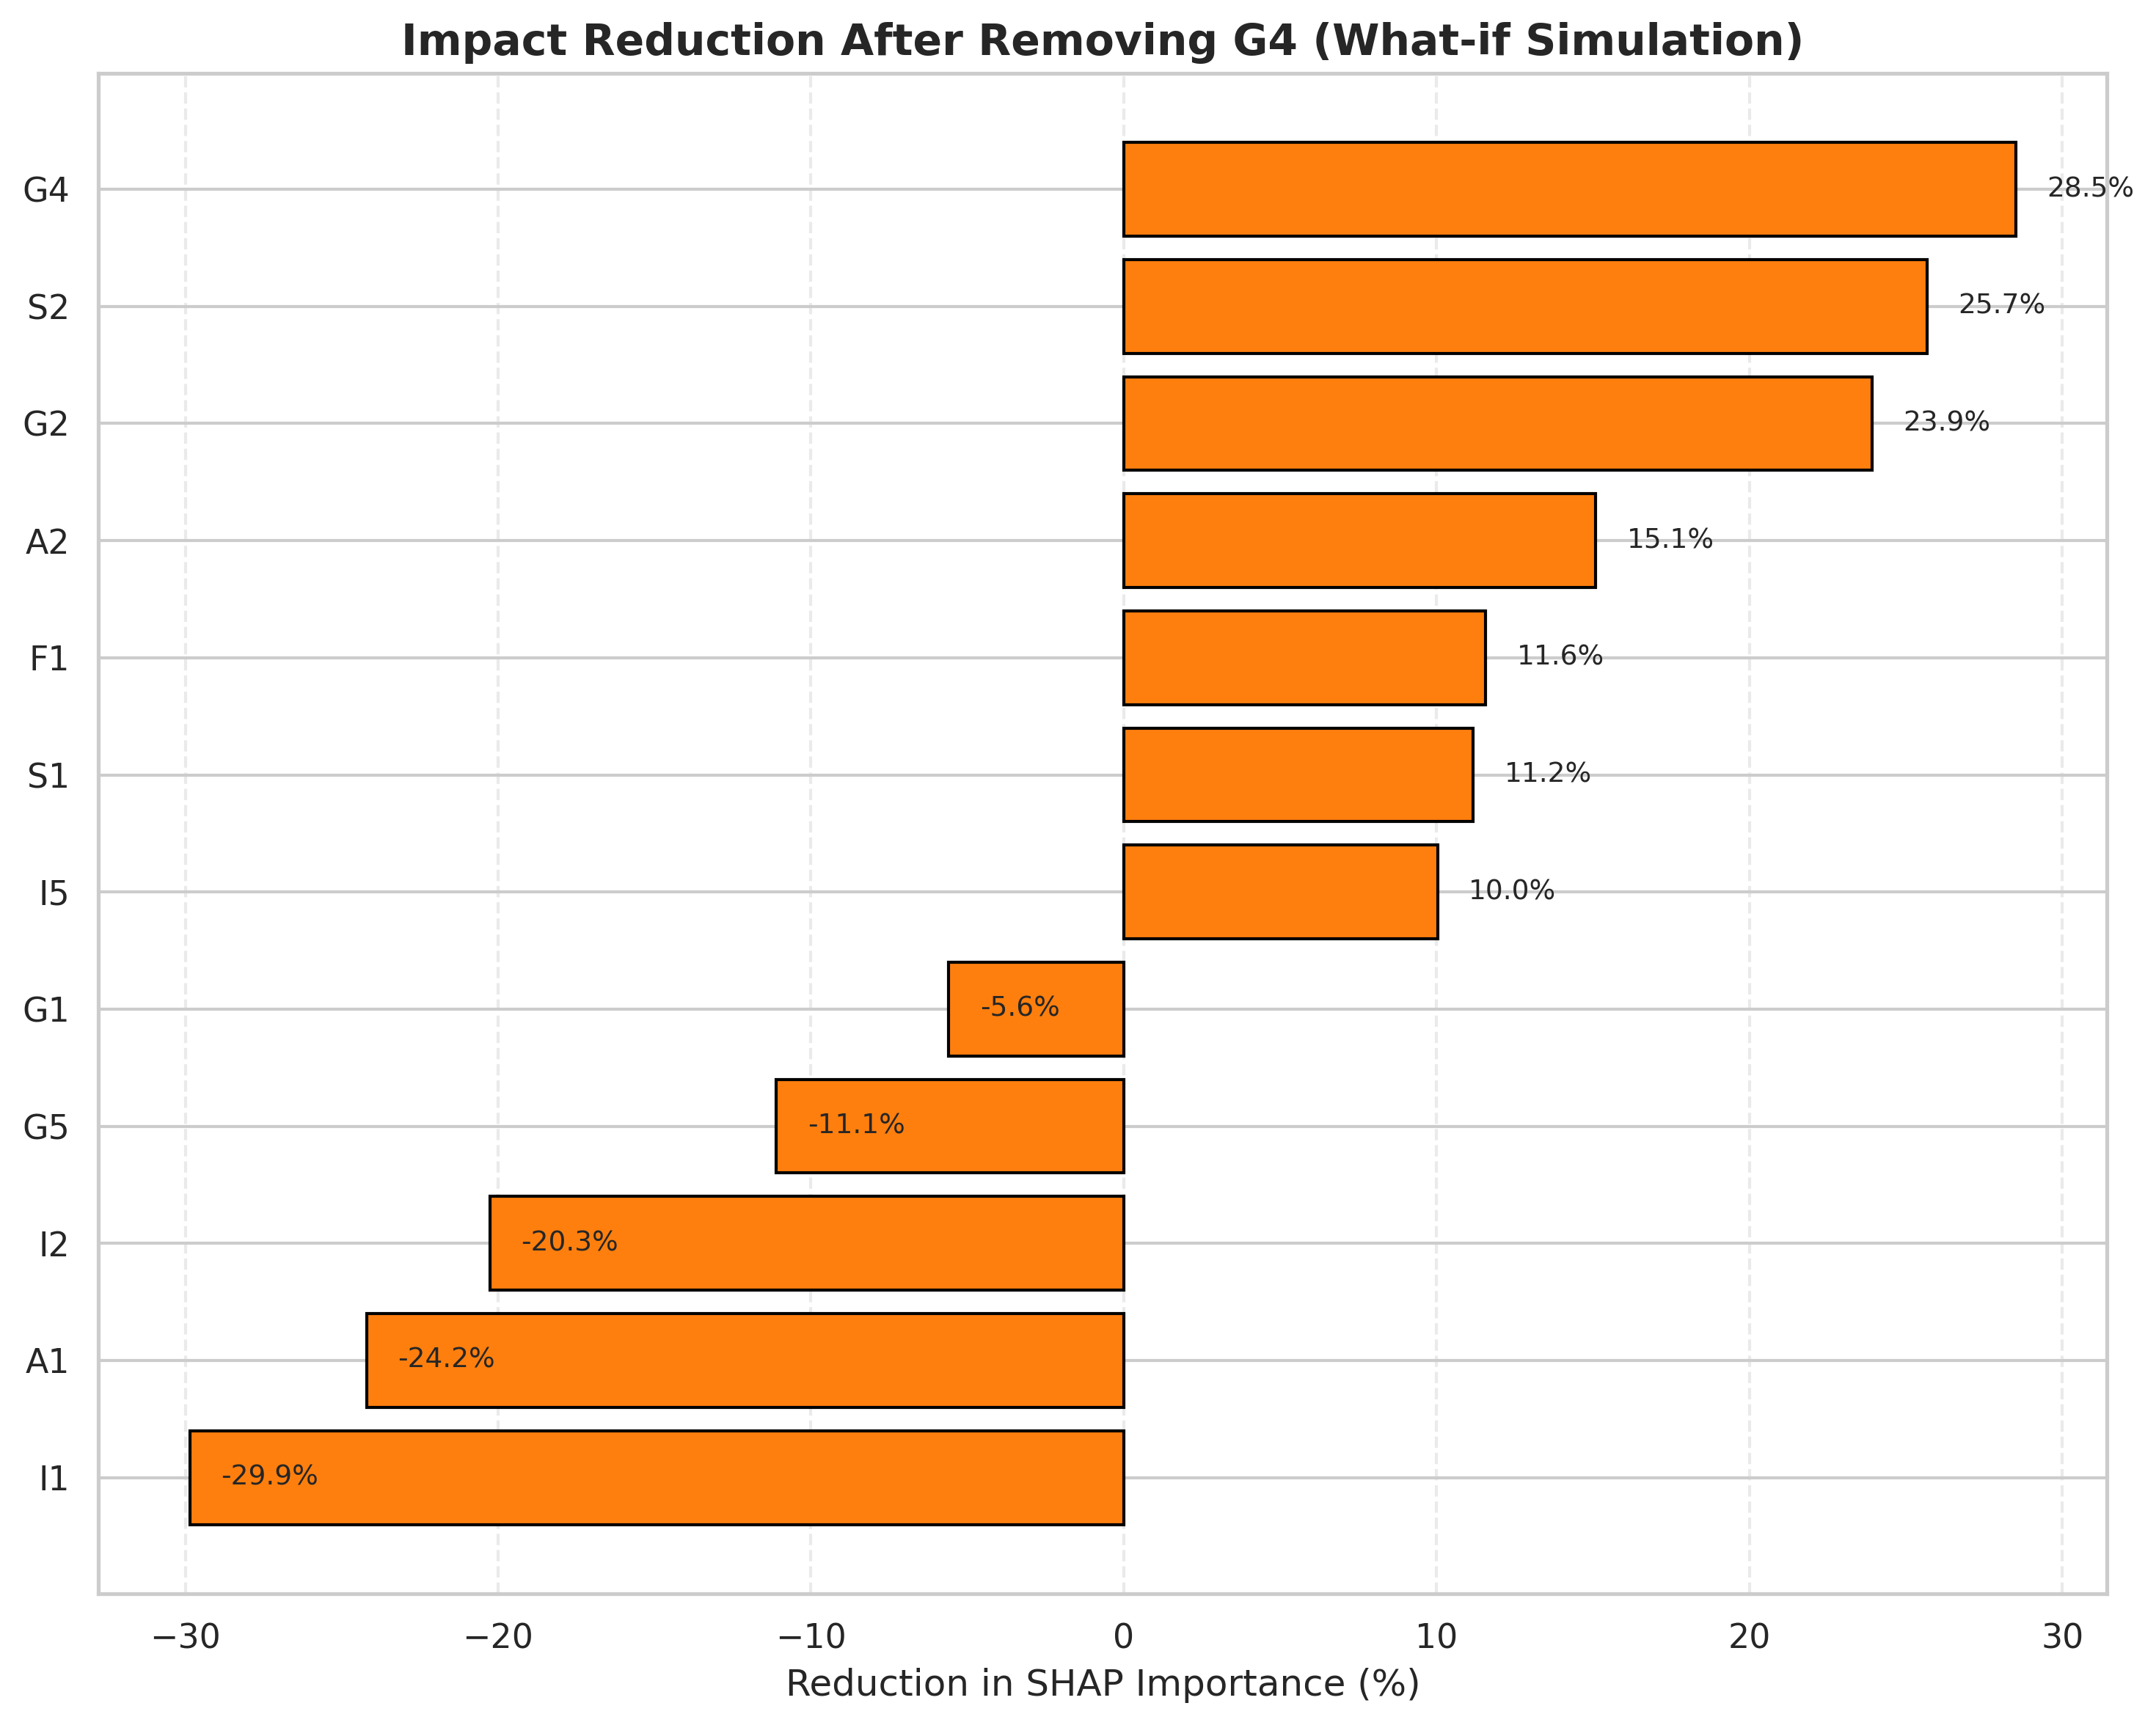

In [28]:
###Impact Reduction After Removing G4 (What-if Simulation)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap

# Simulate scenario: remove G4 as source of impact
df_no_g4 = df.copy()
df_no_g4.loc[df_no_g4['Source'] == 'G4', 'Impact'] = 0

X_no_g4 = pd.get_dummies(df_no_g4[['Source', 'Target']])
X_no_g4 = X_no_g4.reindex(columns=X.columns, fill_value=0)

# Train new model and compute new SHAP values
model_no_g4 = RandomForestRegressor(n_estimators=150, random_state=42)
model_no_g4.fit(X_no_g4, df_no_g4['Impact'])
explainer_no_g4 = shap.Explainer(model_no_g4)
shap_values_no_g4 = explainer_no_g4(X_no_g4)

# Compare mean SHAP values
shap_base = np.abs(shap_values.values).mean(axis=0)
shap_after = np.abs(shap_values_no_g4.values).mean(axis=0)
reduction = (shap_base - shap_after) / shap_base * 100

impact_df = pd.DataFrame({
    'Feature': X.columns,
    'Barrier': X.columns.str.split('_').str[1],
    'Reduction_%': reduction
})
impact_df = impact_df.groupby('Barrier')['Reduction_%'].mean().sort_values(ascending=False).reset_index()

# Plot (high-quality style)
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

bars = ax.barh(
    impact_df['Barrier'],
    impact_df['Reduction_%'],
    color='#ff7f0e',
    edgecolor='black'
)

# Label bars with values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f"{width:.1f}%", va='center', fontsize=9)

# Formatting
ax.set_xlabel("Reduction in SHAP Importance (%)", fontsize=12)
ax.set_title("Impact Reduction After Removing G4 (What-if Simulation)", fontsize=14, weight='bold')
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

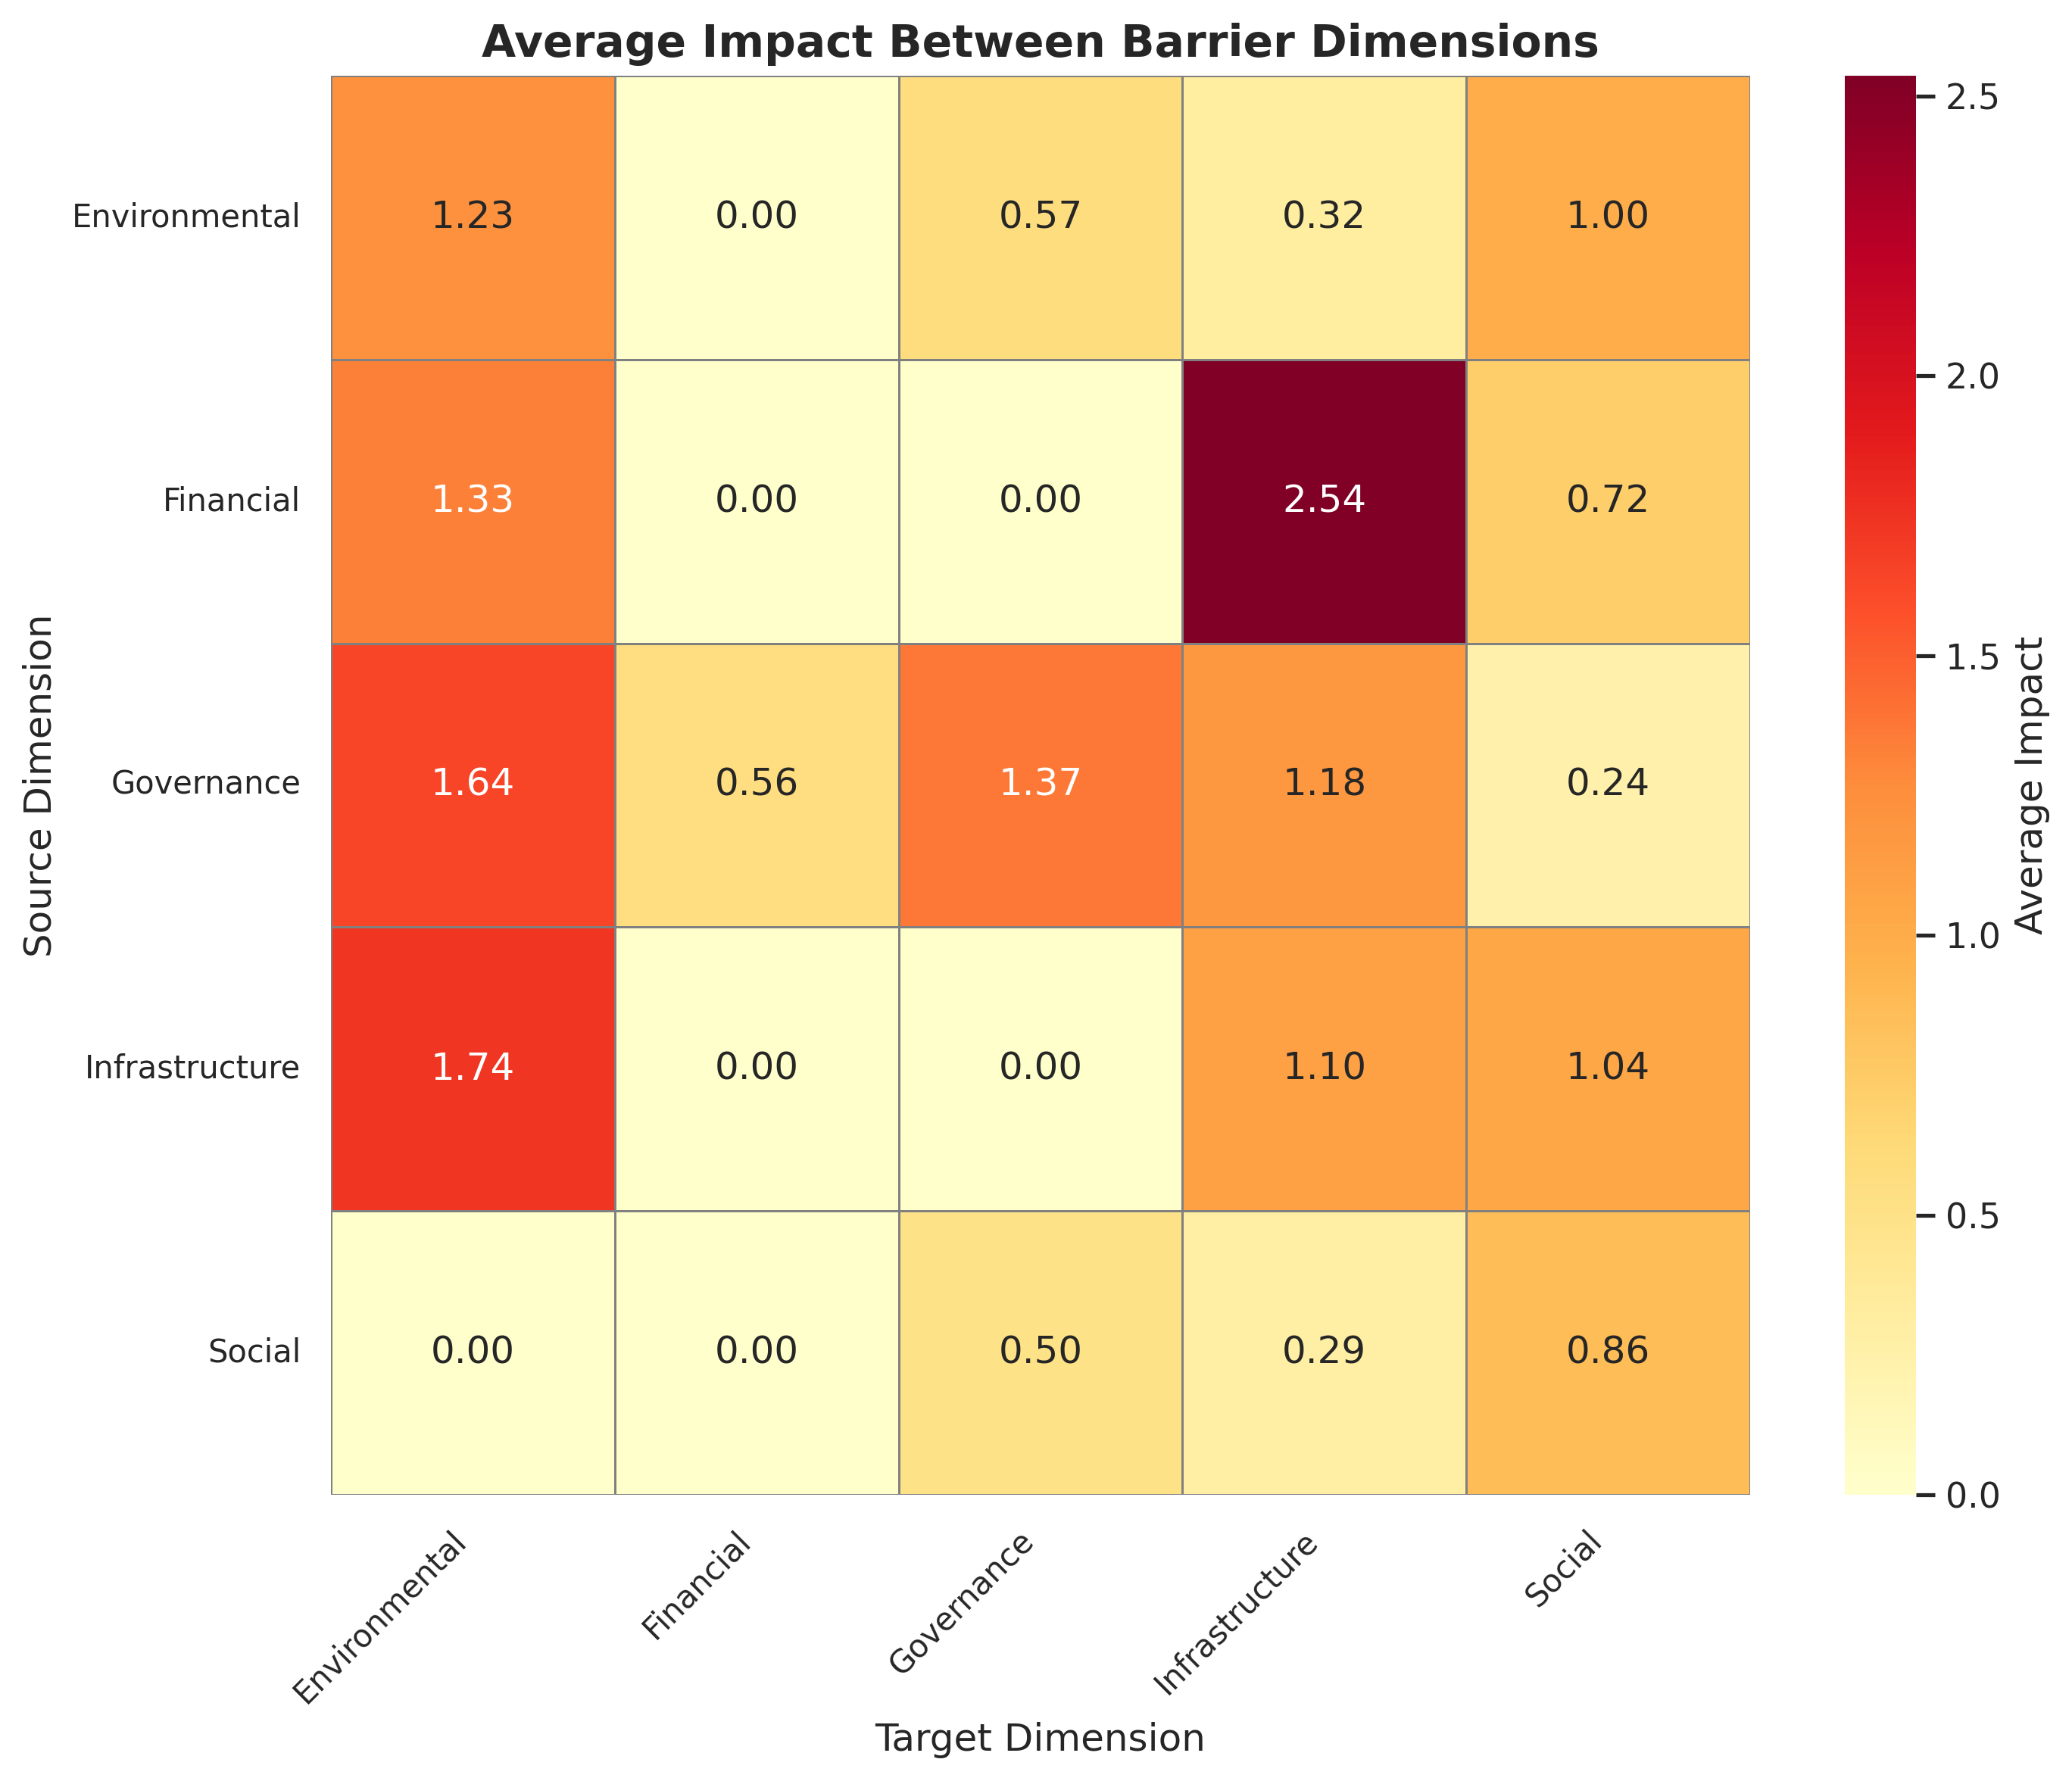

In [29]:
###Average Impact Between Barrier Dimensions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Map of dimensions
dimension_map = {
    'A1': 'Environmental', 'A2': 'Environmental',
    'I1': 'Infrastructure', 'I2': 'Infrastructure', 'I5': 'Infrastructure',
    'G1': 'Governance', 'G2': 'Governance', 'G4': 'Governance', 'G5': 'Governance',
    'F1': 'Financial', 'S1': 'Social', 'S2': 'Social'
}

# Build dimension-level dataframe
data_dim = []
for i in range(len(barriers)):
    for j in range(len(barriers)):
        if i != j and not np.isnan(cross_impact[i, j]):
            data_dim.append({
                'Source': barriers[i],
                'Target': barriers[j],
                'Impact': cross_impact[i, j],
                'Source_Dim': dimension_map[barriers[i]],
                'Target_Dim': dimension_map[barriers[j]]
            })

df_dim = pd.DataFrame(data_dim)

# Create matrix of average impacts between dimensions
dim_matrix = df_dim.groupby(['Source_Dim', 'Target_Dim'])['Impact'].mean().unstack().fillna(0)

# Plot heatmap (publication style)
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

sns.set(style="whitegrid")
heatmap = sns.heatmap(
    dim_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.7,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'Average Impact'}
)

# Labels and title
ax.set_title("Average Impact Between Barrier Dimensions", fontsize=14, weight='bold')
ax.set_xlabel("Target Dimension", fontsize=12)
ax.set_ylabel("Source Dimension", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

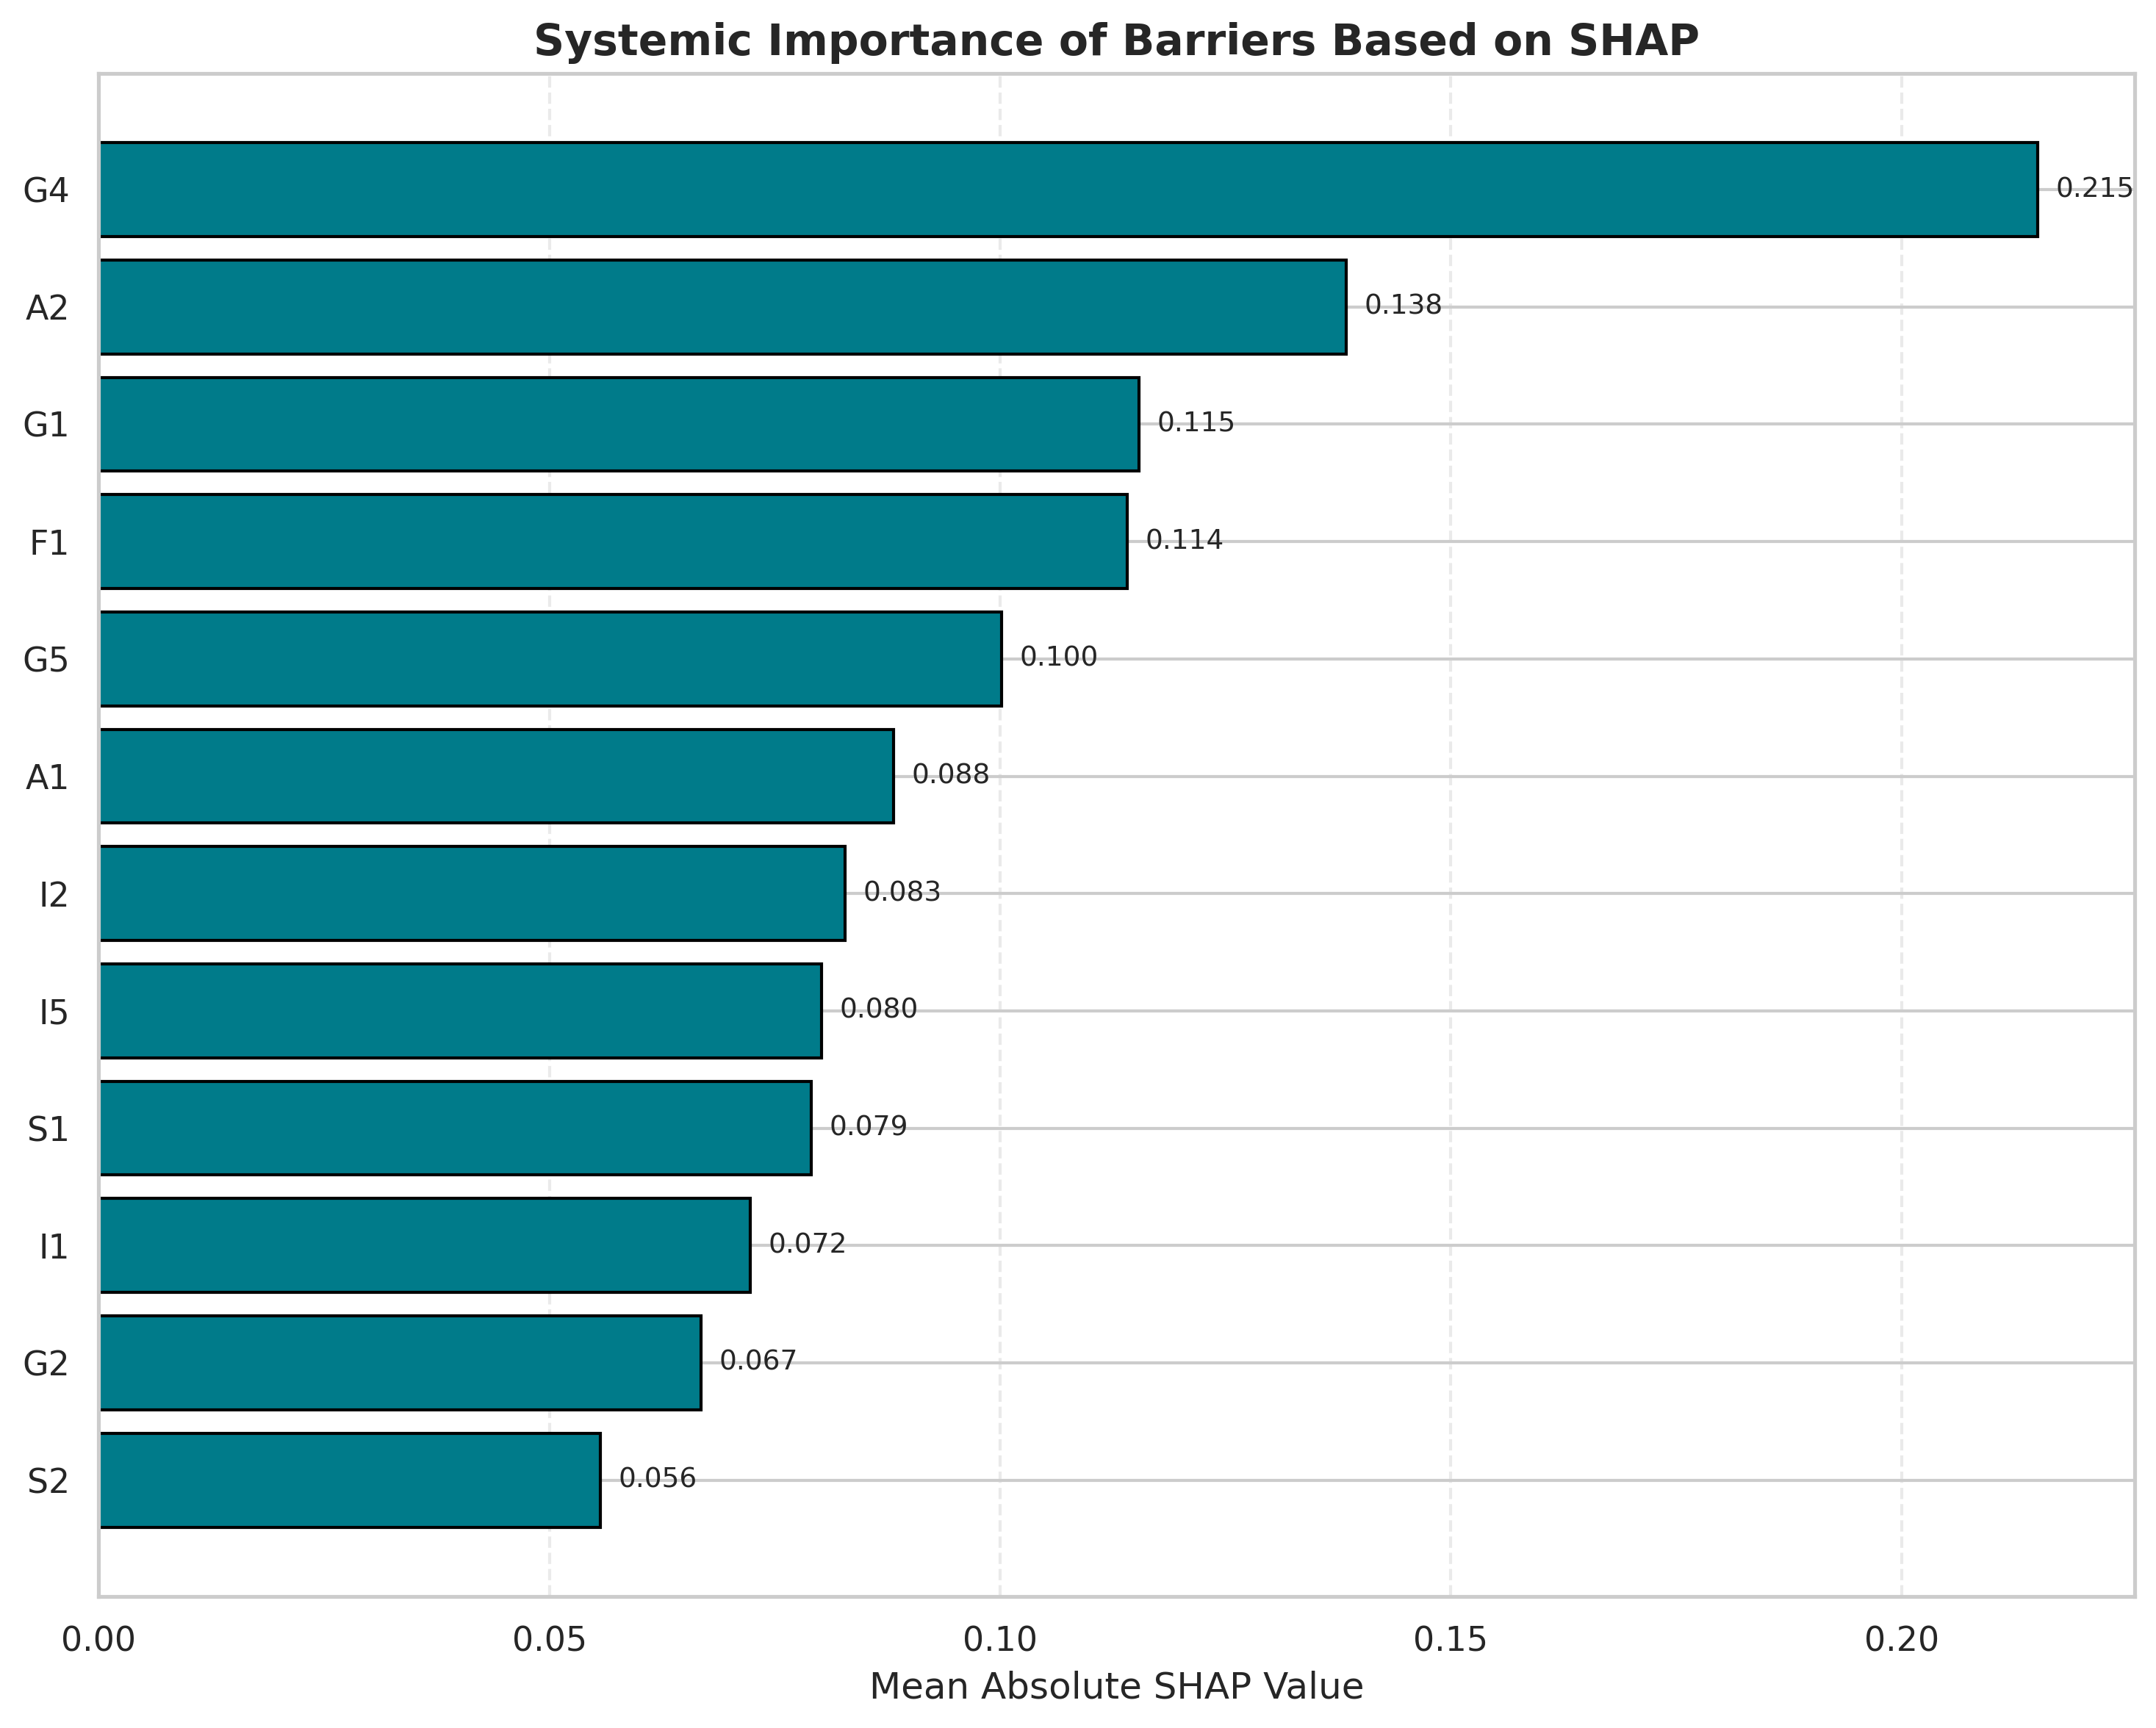

In [30]:
###Systemic Importance of Barriers Based on SHAP
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# Paso 1: convertir la matriz a formato largo
data = []
for i in range(len(barriers)):
    for j in range(len(barriers)):
        if i != j and not np.isnan(cross_impact[i, j]):
            data.append({'Source': barriers[i], 'Target': barriers[j], 'Impact': cross_impact[i, j]})
df = pd.DataFrame(data)

# Paso 2: preparar los datos
X = pd.get_dummies(df[['Source', 'Target']])
y = df['Impact']

# Paso 3: entrenar modelo y calcular SHAP
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Paso 4: ranking SHAP medio por barrera
mean_shap = np.abs(shap_values.values).mean(axis=0)
ranking_df = pd.DataFrame({'Feature': X.columns, 'Mean_SHAP': mean_shap})
ranking_df['Barrier'] = ranking_df['Feature'].str.split('_').str[1]
ranking_summary = ranking_df.groupby('Barrier')['Mean_SHAP'].sum().sort_values(ascending=False).reset_index()

# Paso 5: visualización en estilo publicación (300 DPI)
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

bars = ax.barh(
    ranking_summary['Barrier'],
    ranking_summary['Mean_SHAP'],
    color='#007b8a',  # color sobrio
    edgecolor='black'
)

# Añadir valores al final de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.002, bar.get_y() + bar.get_height()/2,
            f"{width:.3f}", va='center', fontsize=9)

# Ajustes estéticos
ax.set_title("Systemic Importance of Barriers Based on SHAP", fontsize=14, weight='bold')
ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

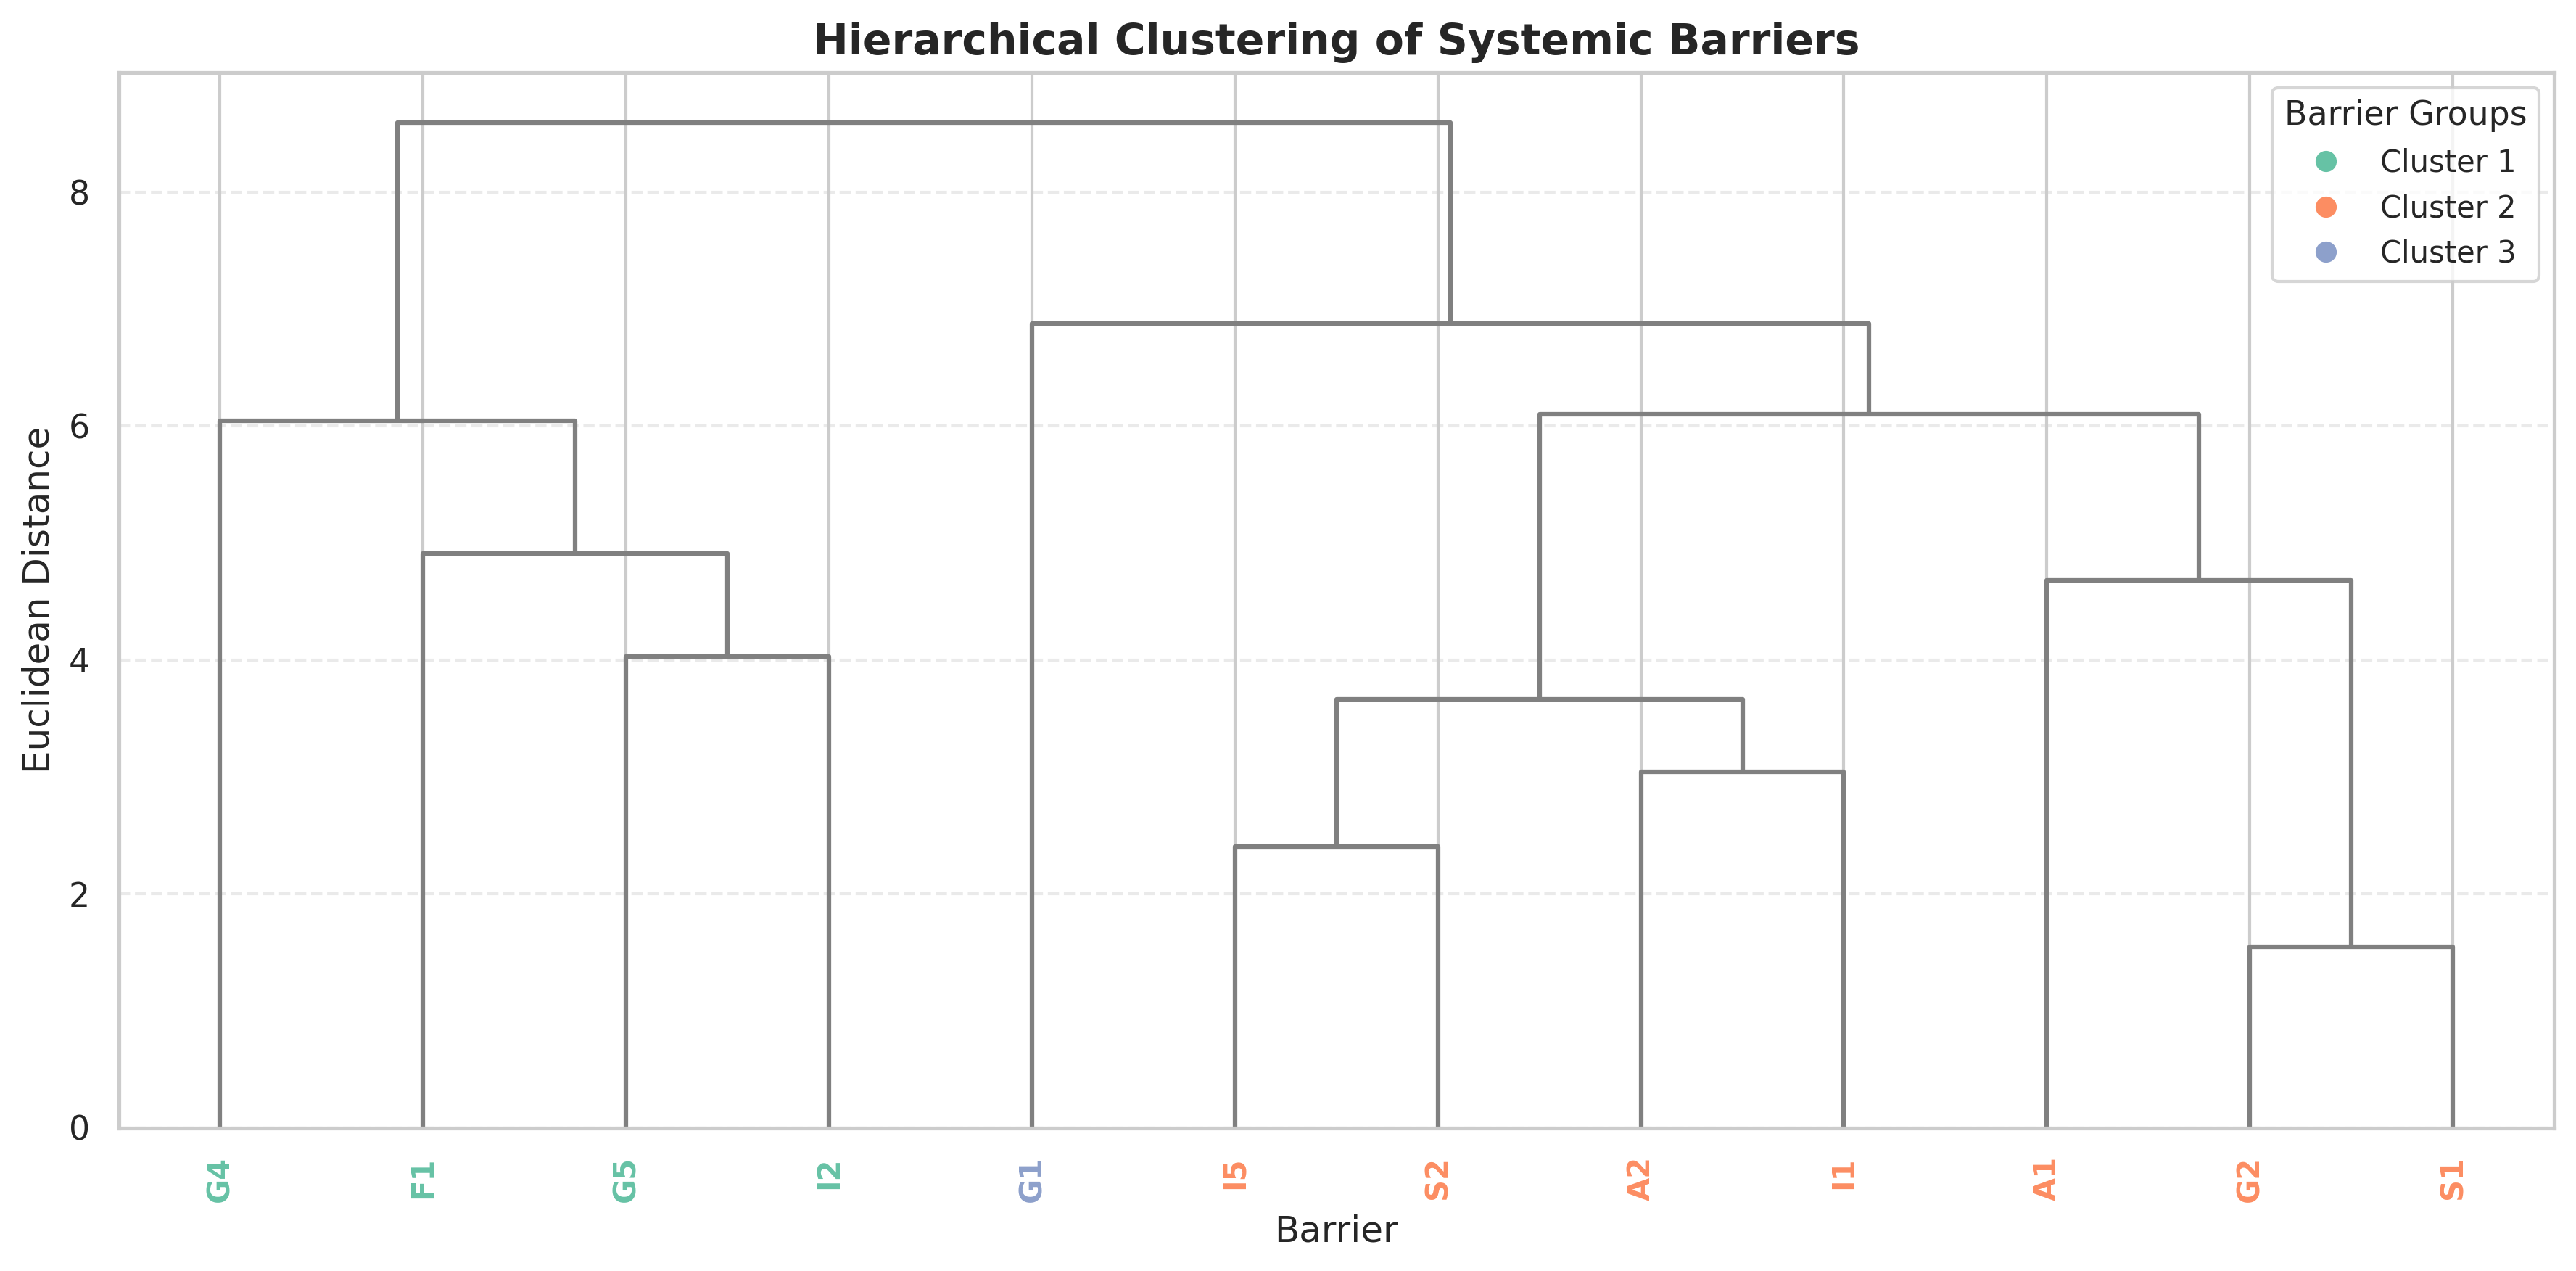

In [34]:
###Hierarchical Clustering of Systemic Barriers
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear matriz fuente → destino
impact_matrix = pd.crosstab(df['Source'], df['Target'], values=df['Impact'], aggfunc='mean').fillna(0)

# 2. Estandarización por filas (z-score)
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(impact_matrix)

# 3. Clustering jerárquico con método Ward
Z = linkage(scaled_matrix, method='ward')

# 4. Definir número de clusters
k = 3
cluster_assignments = fcluster(Z, k, criterion='maxclust')

# 5. Asignar colores suaves por clúster
palette = sns.color_palette("Set2", k)
cluster_colors = {i+1: palette[i] for i in range(k)}
barrier_colors = [cluster_colors[cluster_assignments[i]] for i in range(len(cluster_assignments))]

# 6. Crear gráfico de alta calidad
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

dendro = dendrogram(
    Z,
    labels=impact_matrix.index.tolist(),
    orientation='top',
    leaf_rotation=90,
    leaf_font_size=10,
    above_threshold_color='gray',
    color_threshold=0,
    link_color_func=lambda k: 'gray'
)

# 7. Colorear etiquetas suavemente
for lbl in ax.get_xticklabels():
    label_text = lbl.get_text()
    idx = impact_matrix.index.tolist().index(label_text)
    lbl.set_color(barrier_colors[idx])
    lbl.set_fontweight('bold')

# 8. Título y ejes
ax.set_title("Hierarchical Clustering of Systemic Barriers", fontsize=14, weight='bold')
ax.set_xlabel("Barrier", fontsize=12)
ax.set_ylabel("Euclidean Distance", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 9. Leyenda elegante y limpia
for i, color in cluster_colors.items():
    ax.plot([], [], label=f"Cluster {i}", color=color, marker='o', linestyle='')

ax.legend(title="Barrier Groups", loc='upper right', fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()

<ipython-input-35-3a35f52c5b57>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(shap_dim_grouped.index, rotation=45, ha='right')


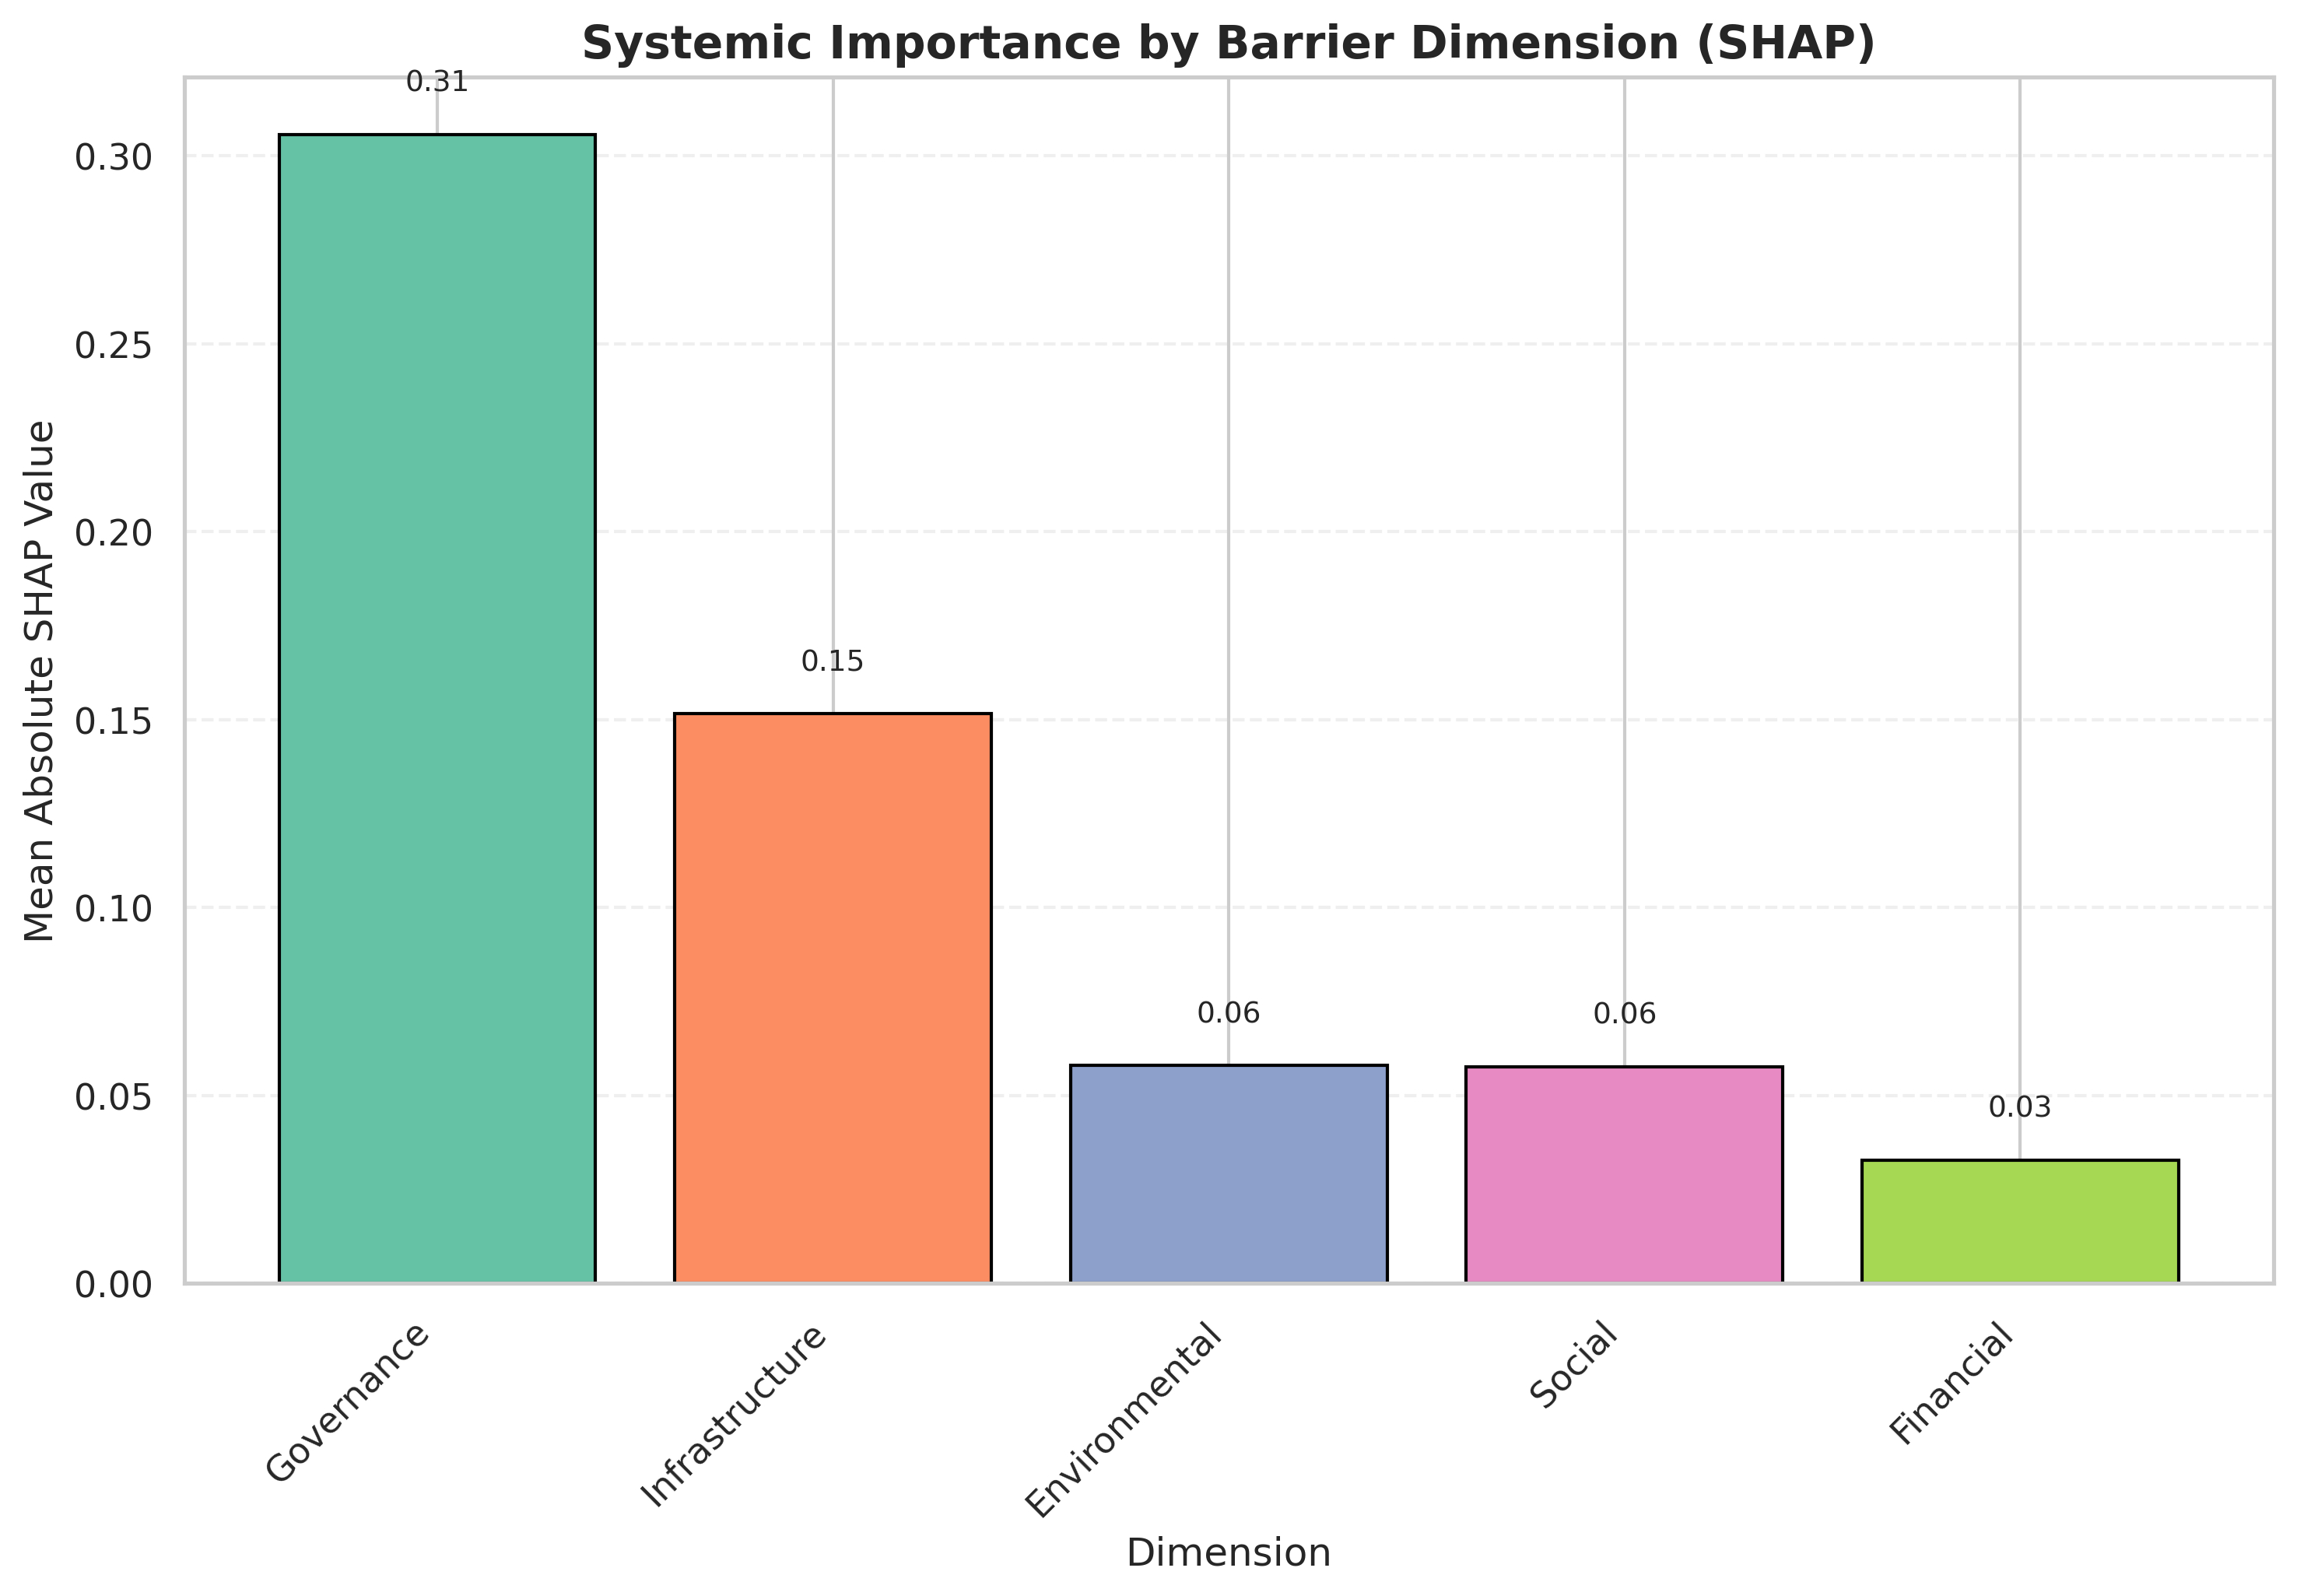

In [35]:
###Systemic Importance by Barrier Dimension (SHAP)
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- Matriz y dimensiones ya definidas ---
# (usa tu matriz `cross_impact`, lista `barriers` y `dimensions` tal como está)

# Formato largo
data = []
for i in range(len(barriers)):
    for j in range(len(barriers)):
        if i != j and not np.isnan(cross_impact[i,j]):
            data.append({
                'Source': barriers[i],
                'Target': barriers[j],
                'Impact': cross_impact[i,j],
                'Source_Dim': dimensions[barriers[i]]
            })
df = pd.DataFrame(data)

# SHAP
X = pd.get_dummies(df[['Source', 'Target']])
y = df['Impact']
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Agrupamiento por dimensión
shap_dim = pd.DataFrame({
    'Barrier': [x.split('_')[1] for x in X.columns[:12]],
    'Dimension': [dimensions[x] for x in barriers],
    'SHAP': np.abs(shap_values.values[:, :12]).mean(axis=0)
})
shap_dim_grouped = shap_dim.groupby('Dimension')['SHAP'].sum().sort_values(ascending=False)

# Gráfico mejorado
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
colors = sns.color_palette("Set2", len(shap_dim_grouped))

bars = ax.bar(
    shap_dim_grouped.index,
    shap_dim_grouped.values,
    color=colors,
    edgecolor='black'
)

# Etiquetas de valor (opcional)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f"{height:.2f}", ha='center', va='bottom', fontsize=9)

# Título y ejes
ax.set_title("Systemic Importance by Barrier Dimension (SHAP)", fontsize=14, weight='bold')
ax.set_ylabel("Mean Absolute SHAP Value", fontsize=12)
ax.set_xlabel("Dimension", fontsize=12)
ax.set_xticklabels(shap_dim_grouped.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

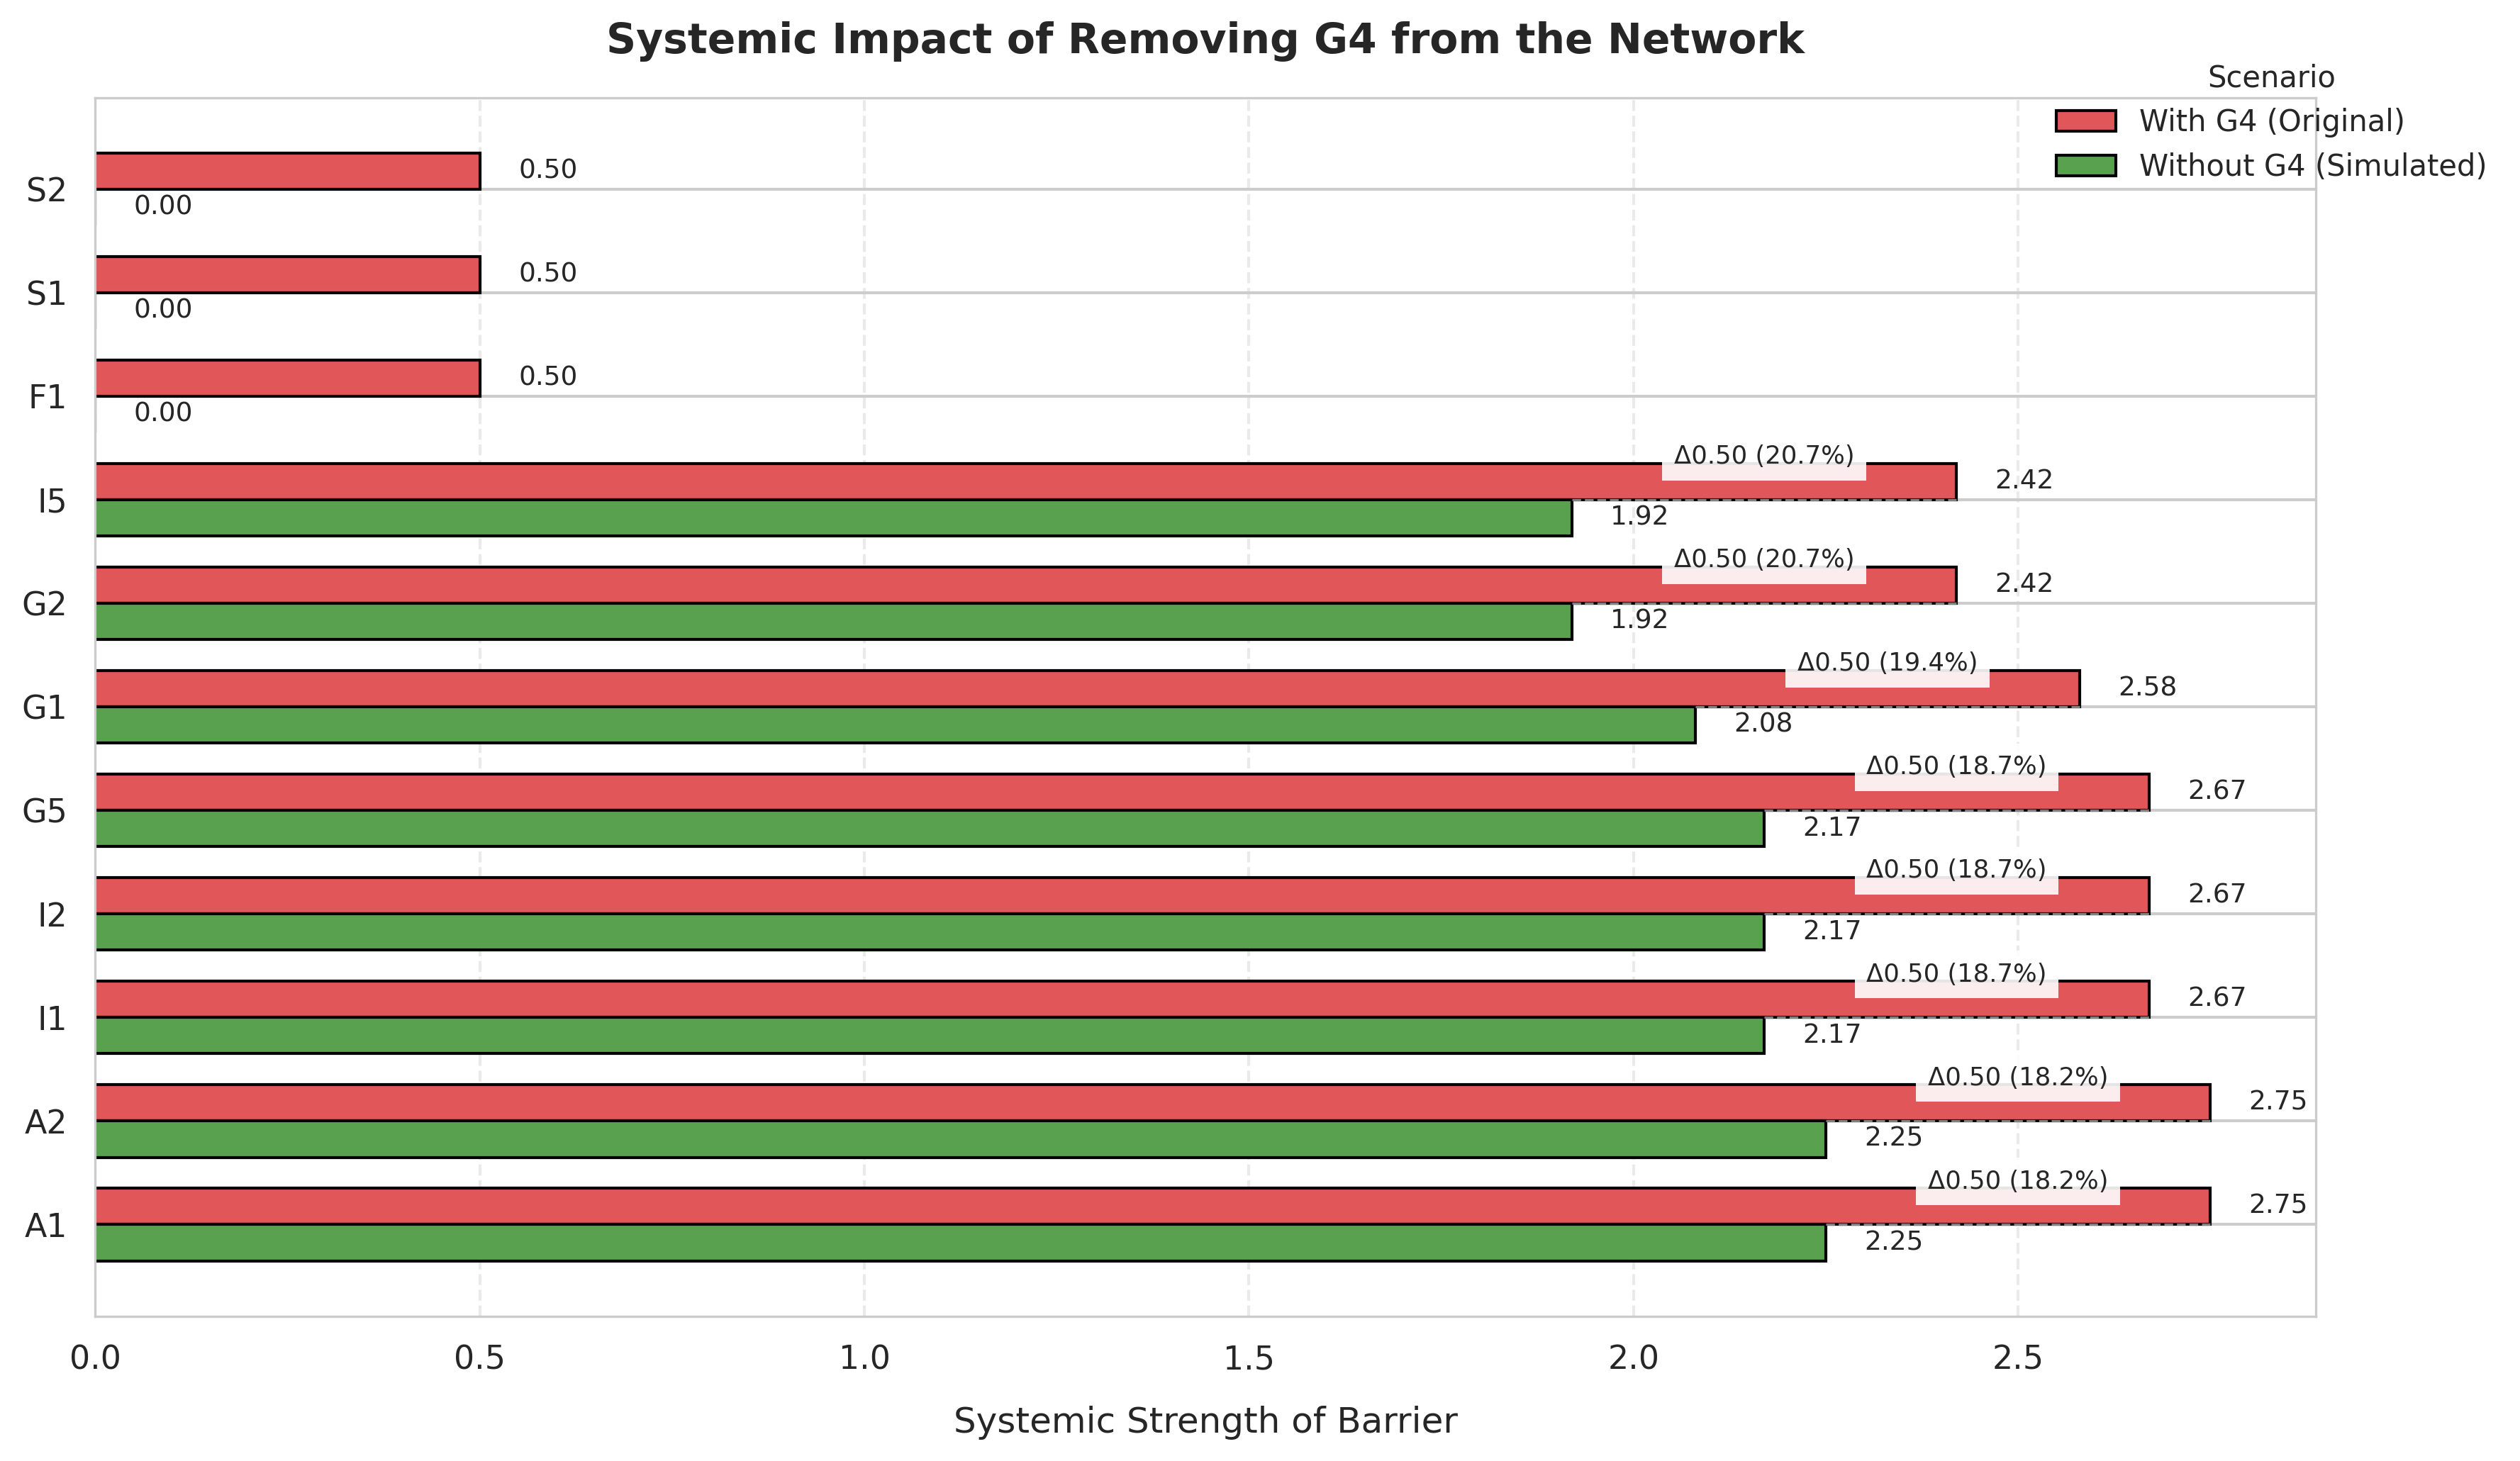

In [39]:
###Systemic Impact of Removing G4 from the Network
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# Datos
barreras = ['A1', 'A2', 'I1', 'I2', 'G5', 'G1', 'G2', 'I5', 'F1', 'S1', 'S2']
fuerza_con_g4 = [2.75, 2.75, 2.67, 2.67, 2.67, 2.58, 2.42, 2.42, 0.5, 0.5, 0.5]
reduccion =     [2.25, 2.25, 2.17, 2.17, 2.17, 2.08, 1.92, 1.92, 0.0, 0.0, 0.0]

diferencia = [round(a - b, 2) for a, b in zip(fuerza_con_g4, reduccion)]
porc_reduccion = [round((a - b) / a * 100, 1) for a, b in zip(fuerza_con_g4, reduccion)]

# Crear figura a 300 DPI
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

x = np.arange(len(barreras))
width = 0.35

# Colores sobrios
color_original = '#E15759'
color_reducido = '#59A14F'

# Barras
rects1 = ax.barh(x + width/2, fuerza_con_g4, width,
                 label='With G4 (Original)', color=color_original, edgecolor='black')
rects2 = ax.barh(x - width/2, reduccion, width,
                 label='Without G4 (Simulated)', color=color_reducido, edgecolor='black')

# Anotar valores
for i, (orig, red, delta, pr) in enumerate(zip(fuerza_con_g4, reduccion, diferencia, porc_reduccion)):
    ax.text(orig + 0.05, i + width/2, f'{orig:.2f}', va='center', fontsize=9)
    ax.text(red + 0.05, i - width/2, f'{red:.2f}', va='center', fontsize=9)
    if red > 0:
        ax.plot([red, orig], [i, i], color='gray', linestyle='--', linewidth=0.8)
        ax.text((red + orig)/2, i + 0.3, f'Δ{delta:.2f} ({pr:.1f}%)',
                ha='center', va='bottom', fontsize=8.5,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))

# Estética del gráfico
ax.set_yticks(x)
ax.set_yticklabels(barreras)
ax.set_xlabel('Systemic Strength of Barrier', labelpad=10)
ax.set_title('Systemic Impact of Removing G4 from the Network', weight='bold', pad=15)
ax.grid(axis='x', linestyle='--', alpha=0.4)

# ✅ Leyenda en parte superior derecha fuera del gráfico
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.98, 1.05),
    ncol=1,
    frameon=False,
    fontsize=10,
    title="Scenario",
    title_fontsize=10
)

plt.tight_layout()
plt.show()

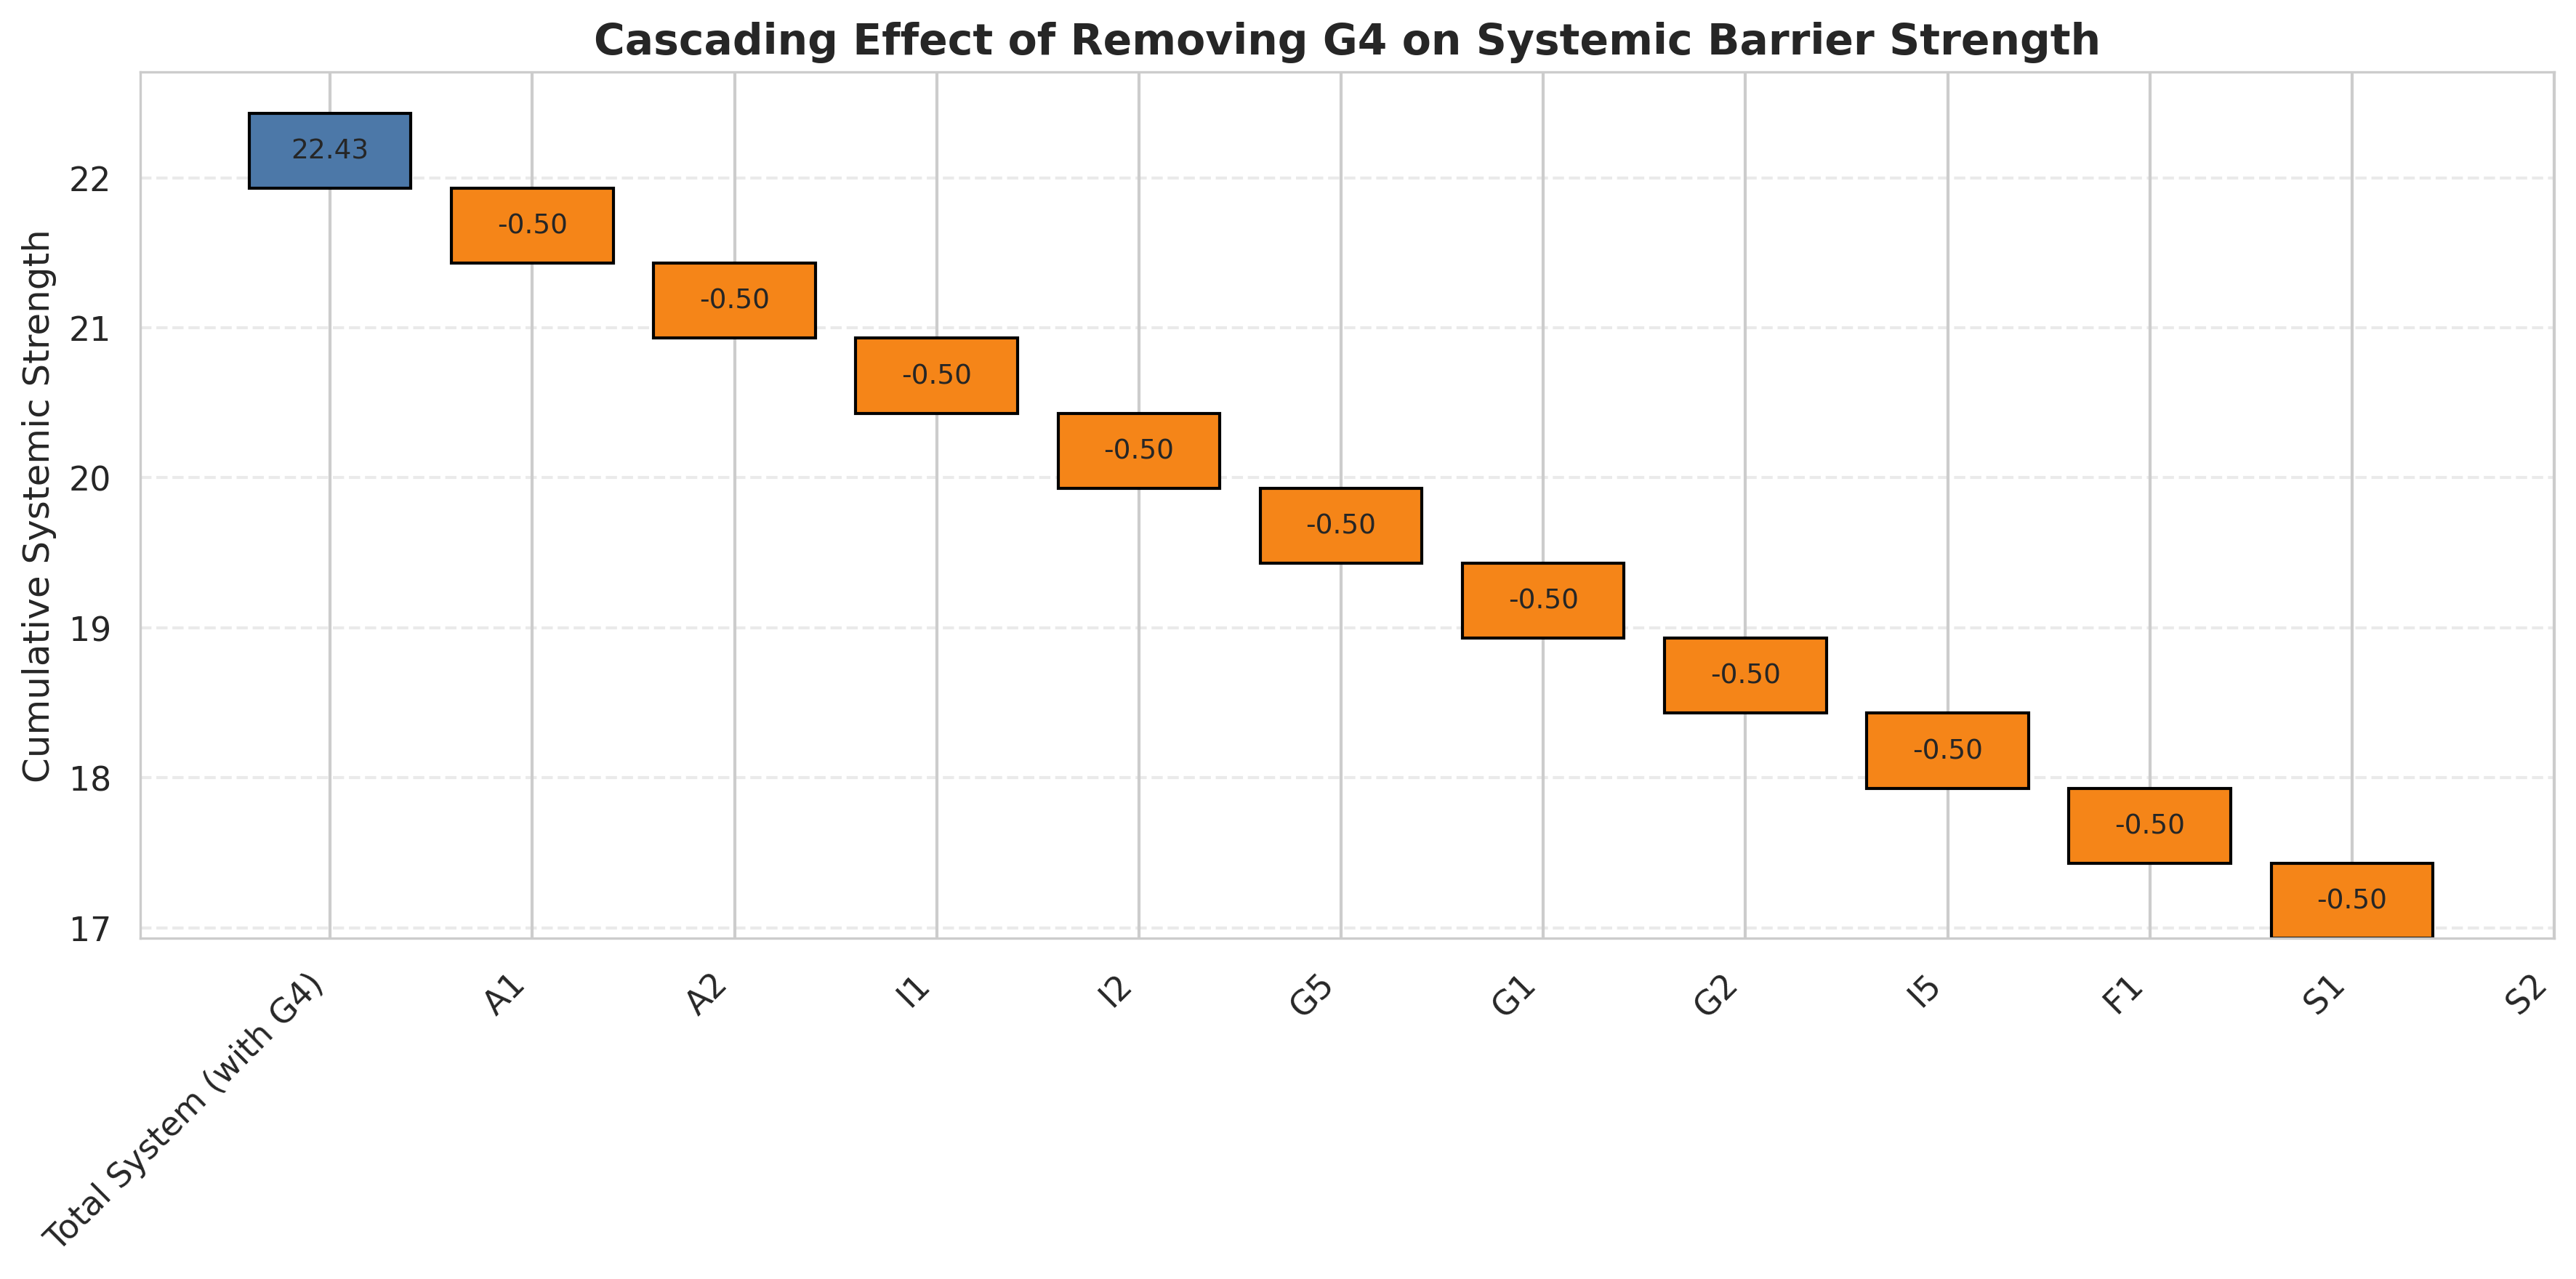

In [42]:
###Cascading Effect of Removing G4 on Systemic Barrier Strength
import numpy as np
import matplotlib.pyplot as plt

# 1. Datos de fuerza con y sin G4
barreras = ['A1', 'A2', 'I1', 'I2', 'G5', 'G1', 'G2', 'I5', 'F1', 'S1', 'S2']
fuerza_con_g4 = np.array([2.75, 2.75, 2.67, 2.67, 2.67, 2.58, 2.42, 2.42, 0.5, 0.5, 0.5])
reduccion =     np.array([2.25, 2.25, 2.17, 2.17, 2.17, 2.08, 1.92, 1.92, 0.0, 0.0, 0.0])

# 2. Calcular deltas y pasos
deltas = fuerza_con_g4 - reduccion
cascada = np.insert(-deltas, 0, fuerza_con_g4.sum())
steps = np.cumsum(cascada)

# 3. Colores: inicio azul, caídas naranjas
colors = ['#4C78A8'] + ['#F58518'] * len(deltas)
etiquetas = ['Total System (with G4)'] + barreras

# 4. Crear figura
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# 5. Dibujar cada bloque de cascada
for i in range(len(steps) - 1):
    height = steps[i] - steps[i + 1]
    ax.bar(i, height, bottom=steps[i + 1], color=colors[i], edgecolor='black')

# 6. Etiquetas numéricas sobre cada bloque
for i in range(len(steps) - 1):
    y_pos = steps[i] - (steps[i] - steps[i + 1]) / 2
    label = f"-{deltas[i - 1]:.2f}" if i > 0 else f"{steps[0]:.2f}"
    ax.text(i, y_pos, label, ha='center', va='center', fontsize=9)

# 7. Estética final
ax.set_xticks(range(len(etiquetas)))
ax.set_xticklabels(etiquetas, rotation=45, ha='right')
ax.set_ylabel("Cumulative Systemic Strength", fontsize=12)
ax.set_title("Cascading Effect of Removing G4 on Systemic Barrier Strength", fontsize=14, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# 8. Guardar como imagen PNG de alta resolución
fig.savefig("fig_cascading_effect_G4.png", dpi=300, bbox_inches='tight')